In [1]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer

from scipy.stats import kruskal, spearmanr, linregress
from statsmodels.stats.multitest import multipletests
from scikit_posthocs import posthoc_dunn
from collections import defaultdict
from itertools import combinations
from typing import List
from scipy import stats
from math import comb
import numpy as np
import random
import pandas as pd
from typing import List, Dict, Tuple, Optional, Any

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats


from matplotlib.patches import Patch, Polygon
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.nonparametric.smoothers_lowess import lowess

import warnings

In [2]:
from massspecgym.tools.data import (compute_cosine_hungarian_score, compute_pairwise_similarity_by_mslevel, compute_same_level_similarity_limited,compute_ancestor_descendant_similarity, compute_sibling_similarity, random_node_pairs)

from massspecgym.tools.plots import plot_histograms, plot_histograms_by_level_pairs
from massspecgym.tools.io import load_embeddings

### functions definitions

In [3]:
def summarize_similarity_distribution_aggregated(scores: List[float]) -> dict:
    """
    Return mean, std, median, count for a list of float scores,
    ignoring NaNs.
    """
    arr = np.array(scores)
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return {"mean": np.nan, "std": np.nan, "median": np.nan, "count": 0}
    return {
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "median": float(np.median(arr)),
        "count": len(arr)
    }

def summarize_similarity_distribution(scores: List[float], normality_alpha: float = 0.05) -> Dict[str, Any]:
    """
    Summarize similarity scores with extended statistics and normality tests.
    
    Parameters:
    - scores: List of similarity scores (floats)
    - normality_alpha: Significance level for normality tests
    
    Returns:
    - Dictionary with comprehensive statistics
    """
    arr = np.array(scores)
    arr = arr[~np.isnan(arr)]
    summary = {}
    
    if len(arr) == 0:
        summary = {
            "mean": np.nan,
            "std": np.nan,
            "median": np.nan,
            "count": 0,
            # "mode": np.nan,
            "q1": np.nan,
            "q3": np.nan,
            "IQR": np.nan,
            "range": np.nan,
            "skewness": np.nan,
            "kurtosis": np.nan,
            "ks_p": np.nan,
            "is_normal": False
        }
        return summary
    
    summary["mean"] = float(np.mean(arr))
    summary["std"] = float(np.std(arr))
    summary["median"] = float(np.median(arr))
    summary["count"] = len(arr)
    # summary["mode"] = float(stats.mode(arr).mode[0])
    summary["q1"] = float(np.percentile(arr, 25))
    summary["q3"] = float(np.percentile(arr, 75))
    summary["IQR"] = summary["q3"] - summary["q1"]
    summary["range"] = float(np.ptp(arr))
    summary["skewness"] = float(stats.skew(arr))
    summary["kurtosis"] = float(stats.kurtosis(arr))
    
    # Kolmogorov-Smirnov Test against normal distribution
    ks_stat, ks_p = stats.kstest(arr, 'norm', args=(summary["mean"], summary["std"]))
    
    summary["ks_p"] = ks_p
    
    # Determine normality based on KS test
    if ks_p >= normality_alpha:
        is_normal = True
    else:
        is_normal = False
    
    summary["is_normal"] = is_normal
    
    return summary


def report_comparison_results(comparison_results: List[Dict[str, Any]]):
    """
    Print comparison results in a structured format.
    
    Parameters:
    - comparison_results: List of dictionaries containing comparison details
    """
    if not comparison_results:
        print("No comparisons to report.")
        return
    
    df = pd.DataFrame(comparison_results)
    
    # Rearrange columns for clarity
    df = df[[
        "Group 1", 
        "Group 2", 
        "Test Used", 
        "Statistic", 
        "p-value", 
        "Adjusted Alpha", 
        "Significant"
    ]]
    
    # Sort by p-value
    df = df.sort_values(by="p-value")
    
    # Display the DataFrame
    print(df.to_string(index=False))
    
def downsample_all_level_sims(all_level_sims_hung, desired_size=None, random_seed=42):
    """
    Downsample each group in the all_level_sims_hung dictionary to the desired_size.
    If desired_size is not specified, it defaults to the size of the smallest group.
    
    Parameters:
    - all_level_sims_hung (dict): Dictionary with Level_Pair tuples as keys and lists of similarity scores as values.
    - desired_size (int, optional): The number of samples to retain in each group.
                                    Defaults to the size of the smallest group.
    - random_seed (int, optional): Seed for reproducibility.
    
    Returns:
    - downsampled_dict (dict): Dictionary with downsampled similarity scores.
    """
    # Set the random seed for reproducibility
    random.seed(random_seed)
    
    # Determine the default desired_size as the size of the smallest group
    if desired_size is None:
        desired_size = min(len(scores) for scores in all_level_sims_hung.values())
        print(f"Desired sample size per group set to the smallest group size: {desired_size}")
    else:
        print(f"Desired sample size per group set to: {desired_size}")
    
    downsampled_dict = {}
    for pair, scores in all_level_sims_hung.items():
        current_size = len(scores)
        if current_size > desired_size:
            # Randomly sample without replacement
            sampled_scores = random.sample(scores, desired_size)
            downsampled_dict[pair] = sampled_scores
            print(f"Downsampled group {pair} from {current_size} to {desired_size}")
        elif current_size < desired_size:
            # Optionally, handle groups smaller than desired_size
            # For now, we'll keep them as is
            downsampled_dict[pair] = scores
            print(f"Group {pair} has only {current_size} samples; no downsampling performed.")
        else:
            # No downsampling needed
            downsampled_dict[pair] = scores
            print(f"Group {pair} already has {desired_size} samples; no downsampling performed.")
    
    return downsampled_dict

def perform_statistical_tests_with_effect_sizes(all_level_sims: Dict[Tuple[int, int], List[float]], alpha: float = 0.05) -> List[Dict[str, Any]]:
    """
    Perform statistical tests between all level pairs and calculate effect sizes.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - alpha: Significance level
    
    Returns:
    - List of dictionaries containing comparison results including effect sizes
    """
    # Summarize distributions and assess normality
    summaries = {level_pair: summarize_similarity_distribution(vals) 
                for level_pair, vals in all_level_sims.items()}
    
    # Prepare for pairwise comparisons
    level_pairs = list(all_level_sims.keys())
    comparison_results = []
    
    # Total number of comparisons for Bonferroni
    m = comb(len(level_pairs), 2) if len(level_pairs) > 1 else 0
    if m > 0:
        adjusted_alpha = alpha / m
    else:
        adjusted_alpha = alpha
    
    # Perform pairwise comparisons
    for (lvlA1, lvlB1), (lvlA2, lvlB2) in combinations(level_pairs, 2):
        # Define comparison labels
        group1_label = f"{lvlA1}-{lvlB1}"
        group2_label = f"{lvlA2}-{lvlB2}"
        
        scores1 = all_level_sims[(lvlA1, lvlB1)]
        scores2 = all_level_sims[(lvlA2, lvlB2)]
        
        summary1 = summaries[(lvlA1, lvlB1)]
        summary2 = summaries[(lvlA2, lvlB2)]
        
        # Decide which test to use based on normality
        if summary1["is_normal"] and summary2["is_normal"]:
            # Perform Welch's t-test
            t_stat, p_val = stats.ttest_ind(scores1, scores2, equal_var=False, nan_policy='omit')
            test_used = "Welch's t-test"
            # Calculate Cohen's d
            mean_diff = summary1["mean"] - summary2["mean"]
            pooled_var = ((summary1["std"]**2) / summary1["count"] + (summary2["std"]**2) / summary2["count"])
            pooled_std = np.sqrt(pooled_var)
            cohen_d = mean_diff / pooled_std
            effect_size = cohen_d
            effect_size_label = "Cohen's d"
        else:
            # Perform Mann-Whitney U test
            u_stat, p_val = stats.mannwhitneyu(scores1, scores2, alternative='two-sided')
            test_used = "Mann-Whitney U test"
            # Calculate Rank-Biserial Correlation as effect size
            n1 = len(scores1)
            n2 = len(scores2)
            rbc = 1 - (2 * u_stat) / (n1 * n2)
            effect_size = rbc
            effect_size_label = "Rank-Biserial Correlation"
        
        # Determine significance with Bonferroni correction
        significant = p_val < adjusted_alpha
        
        comparison_results.append({
            "Group 1": group1_label,
            "Group 2": group2_label,
            "Test Used": test_used,
            "Statistic": t_stat if test_used == "Welch's t-test" else u_stat,
            "p-value": p_val,
            "Adjusted Alpha": adjusted_alpha,
            "Significant": significant,
            "Effect Size": effect_size,
            "Effect Size Type": effect_size_label
        })
    
    return comparison_results

def report_comparison_results_with_effect_sizes(comparison_results: List[Dict[str, Any]]):
    """
    Print comparison results with effect sizes in a structured format.
    
    Parameters:
    - comparison_results: List of dictionaries containing comparison details
    """
    if not comparison_results:
        print("No comparisons to report.")
        return
    
    df = pd.DataFrame(comparison_results)
    
    # Rearrange columns for clarity
    df = df[[
        "Group 1", 
        "Group 2", 
        "Test Used", 
        "Statistic", 
        "p-value", 
        "Adjusted Alpha",
        "Significant",
        "Effect Size",
        "Effect Size Type"
    ]]
    
    # Sort by p-value
    df = df.sort_values(by="p-value")
    
    # Display the DataFrame
    print(df.to_string(index=False))
    
def compare_target_group_against_others(
    all_level_sims: Dict[Tuple[int, int], List[float]],
    target_level_pair: Tuple[int, int],
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Compare the target level pair's similarity scores against all other level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - target_level_pair: Tuple indicating the target level pair (e.g., (2,2))
    - alpha: Significance level
    
    Returns:
    - Pandas DataFrame with comparison results
    """
    target_scores = all_level_sims.get(target_level_pair, [])
    if not target_scores:
        raise ValueError(f"No similarity scores found for target level pair {target_level_pair}")
    
    # Summarize the target group
    summary_target = summarize_similarity_distribution(target_scores)
    
    comparison_results = []
    
    # Number of comparisons for Bonferroni correction
    other_level_pairs = [lp for lp in all_level_sims.keys() if lp != target_level_pair]
    m = len(other_level_pairs)
    if m == 0:
        raise ValueError("No other level pairs to compare against.")
    adjusted_alpha = alpha / m  # Bonferroni correction
    
    # Iterate over all other level pairs
    for level_pair in other_level_pairs:
        other_scores = all_level_sims[level_pair]
        summary_other = summarize_similarity_distribution(other_scores)
        
        # Decide which test to use based on normality
        if summary_target["is_normal"] and summary_other["is_normal"]:
            # Perform Welch's t-test
            t_stat, p_val = stats.ttest_ind(target_scores, other_scores, equal_var=False, nan_policy='omit')
            test_used = "Welch's t-test"
            # Calculate Cohen's d
            mean_diff = summary_target["mean"] - summary_other["mean"]
            pooled_var = ((summary_target["std"]**2) / summary_target["count"] + 
                         (summary_other["std"]**2) / summary_other["count"])
            pooled_std = np.sqrt(pooled_var)
            cohen_d = mean_diff / pooled_std
            effect_size = cohen_d
            effect_size_label = "Cohen's d"
        else:
            # Perform Mann-Whitney U test
            try:
                u_stat, p_val = stats.mannwhitneyu(target_scores, other_scores, alternative='two-sided')
            except ValueError as e:
                # Handle cases where all values are identical
                u_stat, p_val = np.nan, np.nan
            test_used = "Mann-Whitney U test"
            # Calculate Rank-Biserial Correlation as effect size
            if not np.isnan(u_stat):
                n1 = len(target_scores)
                n2 = len(other_scores)
                rbc = 1 - (2 * u_stat) / (n1 * n2)
            else:
                rbc = np.nan
            effect_size = rbc
            effect_size_label = "Rank-Biserial Correlation"
        
        # Determine significance with Bonferroni correction
        significant = p_val < adjusted_alpha if not np.isnan(p_val) else False
        
        comparison_results.append({
            "Target Group": f"{target_level_pair}",
            "Compared Group": f"{level_pair}",
            "Test Used": test_used,
            "Statistic": t_stat if test_used == "Welch's t-test" else u_stat,
            "p-value": p_val,
            "Adjusted Alpha": adjusted_alpha,
            "Significant": significant,
            "Effect Size": effect_size,
            "Effect Size Type": effect_size_label
        })
    
    # Convert to DataFrame for better readability
    df_results = pd.DataFrame(comparison_results)
    
    # Sort by p-value
    df_results = df_results.sort_values(by="p-value")
    
    return df_results

def convert_similarity_scores(similarity_scores):
    """
    Convert a list of numpy.ndarray similarity scores to a list of floats.
    
    Parameters:
    - similarity_scores: List of numpy.ndarray objects containing single floats
    
    Returns:
    - List of floats
    """
    return [float(score) for score in similarity_scores]

def plot_histogram_kde(all_level_sims: Dict[Tuple[int, int], List[float]], target_level_pair: Tuple[int, int], title: str):
    """
    Plot histogram with KDE overlay for a specific level pair.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - target_level_pair: Tuple indicating the target level pair (e.g., (2,2))
    - title: Title of the plot
    """
    sims = all_level_sims.get(target_level_pair, [])
    
    # Diagnostic Prints
    print(f"Type of sims: {type(sims)}")
    print(f"Length of sims: {len(sims)}")
    if isinstance(sims, list):
        if len(sims) > 0:
            print(f"First 5 elements: {sims[:5]}")
        else:
            print("sims list is empty.")
    else:
        print("sims is not a list.")
    
    if not sims:
        print(f"No similarity scores found for level pair {target_level_pair}.")
        return
    
    # Ensure all elements are numeric
    sims_numeric = [score for score in sims if isinstance(score, (int, float, np.integer, np.floating))]
    non_numeric = len(sims) - len(sims_numeric)
    if non_numeric > 0:
        print(f"Removed {non_numeric} non-numeric similarity scores.")

    if not sims_numeric:
        print(f"No numeric similarity scores available for level pair {target_level_pair}.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.histplot(sims_numeric, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')
    plt.title(f"{title} for Level Pair {target_level_pair}")
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.xlim(-0.1, 1.1)  # Adjust based on similarity score range
    plt.show()

def plot_boxplots(all_level_sims: Dict[Tuple[int, int], List[float]], title: str):
    """
    Plot boxplots of similarity scores for multiple level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - title: Title of the plot
    """
    data = []
    for (lvlA, lvlB), sims in all_level_sims.items():
        label = f"{lvlA}-{lvlB}"
        for sim in sims:
            data.append({"Level Pair": label, "Similarity": sim})
    
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x="Level Pair", y="Similarity", data=df, palette="Set3")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel("MS Level Pair")
    plt.ylabel("Similarity Score")
    plt.show()
    
def plot_density(all_level_sims: Dict[Tuple[int, int], List[float]], title: str):
    """
    Plot density plots of similarity scores for all level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - title: Title of the plot
    """
    plt.figure(figsize=(14, 8))
    for (lvlA, lvlB), sims in all_level_sims.items():
        label = f"{lvlA}-{lvlB}"
        sns.kdeplot(sims, label=label, shade=False)
    
    plt.title(title)
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend(title="MS Level Pairs", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
def plot_comparative_histogram(all_level_sims: Dict[Tuple[int, int], List[float]], target_level_pair: Tuple[int, int], compare_level_pair: Tuple[int, int], title: str):
    """
    Plot comparative histograms for two specific level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - target_level_pair: Tuple indicating the target level pair (e.g., (2,2))
    - compare_level_pair: Tuple indicating the comparison level pair (e.g., (2,3))
    - title: Title of the plot
    """
    sims_target = all_level_sims.get(target_level_pair, [])
    sims_compare = all_level_sims.get(compare_level_pair, [])
    
    if not sims_target or not sims_compare:
        print(f"Insufficient data for comparison between {target_level_pair} and {compare_level_pair}.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.histplot(sims_target, bins=50, kde=True, stat="density", label=f"{target_level_pair}", color='blue', alpha=0.5)
    sns.histplot(sims_compare, bins=50, kde=True, stat="density", label=f"{compare_level_pair}", color='orange', alpha=0.5)
    plt.title(title)
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend(title="MS Level Pairs")
    plt.xlim(-0.1, 1.1)
    plt.show()
    
def fit_distributions(data: List[float], distributions: List[str] = None) -> pd.DataFrame:
    """
    Fit multiple distributions to the data and evaluate goodness-of-fit using KS statistic.
    
    Parameters:
    - data: List of similarity scores (floats)
    - distributions: List of distribution names to fit. If None, a default list is used.
    
    Returns:
    - DataFrame with distribution parameters and KS statistics
    """
    if distributions is None:
        distributions = [
            'norm', 'expon', 'beta', 'gamma', 'lognorm', 'uniform', 'weibull_min',
            'weibull_max', 'pareto', 't', 'cauchy'
        ]
    
    results = []
    data = np.array(data)
    
    # Remove NaN values
    data = data[~np.isnan(data)]
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            # Fit distribution to data
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                params = dist.fit(data)
            
            # Perform KS test
            ks_stat, ks_p = stats.kstest(data, dist_name, args=params)
            
            # Append results
            results.append({
                'Distribution': dist_name,
                'Parameters': params,
                'KS Statistic': ks_stat,
                'KS p-value': ks_p
            })
        except Exception as e:
            print(f"Could not fit distribution {dist_name}: {e}")
            continue
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='KS Statistic')
    return results_df

def fit_distributions_with_aic(data: List[float], distributions: List[str] = None) -> pd.DataFrame:
    """
    Fit multiple distributions to the data and evaluate goodness-of-fit using AIC.
    
    Parameters:
    - data: List of similarity scores (floats)
    - distributions: List of distribution names to fit. If None, a default list is used.
    
    Returns:
    - DataFrame with distribution parameters and AIC scores
    """
    if distributions is None:
        distributions = [
            'norm', 'expon', 'beta', 'gamma', 'lognorm', 'uniform', 'weibull_min',
            'weibull_max', 'pareto', 't', 'cauchy'
        ]
    
    results = []
    data = np.array(data)
    
    # Remove NaN values
    data = data[~np.isnan(data)]
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            # Fit distribution to data
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                params = dist.fit(data)
            
            # Calculate log-likelihood
            log_likelihood = np.sum(dist.logpdf(data, *params))
            
            # Number of parameters
            k = len(params)
            
            # Calculate AIC
            aic = 2*k - 2*log_likelihood
            
            # Append results
            results.append({
                'Distribution': dist_name,
                'Parameters': params,
                'AIC': aic
            })
        except Exception as e:
            print(f"Could not fit distribution {dist_name}: {e}")
            continue
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='AIC')
    return results_df

def identify_top_fits(df: pd.DataFrame, criterion: str = 'KS Statistic', top_n: int = 5) -> pd.DataFrame:
    """
    Identify the top N best-fitting distributions based on a specified criterion.
    
    Parameters:
    - df: DataFrame containing distribution fit results
    - criterion: Column name to sort by ('KS Statistic' or 'AIC')
    - top_n: Number of top distributions to return
    
    Returns:
    - DataFrame of top N distributions
    """
    if criterion not in df.columns:
        raise ValueError(f"Criterion '{criterion}' not found in DataFrame columns.")
    
    top_fits = df.nsmallest(top_n, criterion)
    return top_fits

def summarize_all_level_pairs(
    all_level_sims: Dict[Tuple[int, int], List[float]],
    top_n: int = 5
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fit distributions to all level pairs and summarize the top N best-fitting distributions based on KS and AIC.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores (floats)
    - top_n: Number of top distributions to include in the summary
    
    Returns:
    - Tuple containing two DataFrames:
        1. Summary based on KS Statistic
        2. Summary based on AIC
    """
    ks_summary = []
    aic_summary = []
    
    for level_pair, sims in all_level_sims.items():
        if len(sims) == 0:
            print(f"Level pair {level_pair} has no similarity scores. Skipping.")
            continue
        print(f"\nFitting distributions for Level Pair {level_pair} with {len(sims)} scores...")
        
        # Fit distributions and compute KS statistics
        ks_df = fit_distributions(sims)
        if ks_df.empty:
            print(f"No distributions were successfully fitted for Level Pair {level_pair}.")
            continue
        top_ks = identify_top_fits(ks_df, criterion='KS Statistic', top_n=top_n)
        top_ks = top_ks.copy()
        top_ks['Level Pair'] = f"{level_pair[0]},{level_pair[1]}"  # Convert tuple to string
        ks_summary.append(top_ks)
        
        # Fit distributions and compute AIC
        aic_df = fit_distributions_with_aic(sims)
        if aic_df.empty:
            print(f"No distributions were successfully fitted for Level Pair {level_pair} based on AIC.")
            continue
        top_aic = identify_top_fits(aic_df, criterion='AIC', top_n=top_n)
        top_aic = top_aic.copy()
        top_aic['Level Pair'] = f"{level_pair[0]},{level_pair[1]}"  # Convert tuple to string
        aic_summary.append(top_aic)
    
    # Concatenate all summaries
    if ks_summary:
        ks_summary_df = pd.concat(ks_summary, ignore_index=True)
    else:
        ks_summary_df = pd.DataFrame()
    if aic_summary:
        aic_summary_df = pd.concat(aic_summary, ignore_index=True)
    else:
        aic_summary_df = pd.DataFrame()
    
    return ks_summary_df, aic_summary_df

def plot_histogram_with_best_fit(data: List[float], best_fit_dist: str, title: str):
    """
    Plot histogram with KDE and the best-fitting distribution's PDF.
    
    Parameters:
    - data: List of similarity scores (floats)
    - best_fit_dist: Name of the best-fitting distribution
    - title: Title of the plot
    """
    dist = getattr(stats, best_fit_dist)
    params = dist.fit(data)
    
    # Create range for x-axis
    x = np.linspace(min(data), max(data), 1000)
    pdf = dist.pdf(x, *params)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black', label='Data')
    plt.plot(x, pdf, 'r-', label=f'{best_fit_dist} PDF')
    plt.title(f"{title} with Best-Fitting Distribution ({best_fit_dist})")
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.xlim(-0.1, 1.1)  # Adjust based on similarity score range
    plt.show()
    

def plot_best_fit(
    summary_df: pd.DataFrame,
    all_level_sims: Dict[Tuple[int, int], List[float]],
    criterion: str = 'KS Statistic',
    save_plots: bool = False
):
    """
    Plot histogram with KDE and the best-fitting distribution's PDF for each level pair based on the specified criterion.
    
    Parameters:
    - summary_df: DataFrame containing distribution fit results (either KS or AIC based).
    - all_level_sims: Dict mapping level pairs to list of similarity scores (floats).
    - criterion: Criterion to select distributions ('KS Statistic' or 'AIC').
    - save_plots: If True, saves the plots as PNG files.
    """
    # Ensure the criterion is valid
    if criterion not in ['KS Statistic', 'AIC']:
        raise ValueError("Criterion must be either 'KS Statistic' or 'AIC'")
    
    # Define the column to sort by based on the criterion
    if criterion == 'KS Statistic':
        stat_col = 'KS Statistic'
    else:
        stat_col = 'AIC'
    
    # Sort the DataFrame based on 'Level Pair' and the criterion
    sorted_df = summary_df.sort_values(['Level Pair', stat_col], ascending=[True, True])
    
    # Group by 'Level Pair' and take the first entry in each group (best fit)
    best_fits = sorted_df.groupby('Level Pair').first().reset_index()
    
    # Iterate over each level pair and plot
    for _, row in best_fits.iterrows():
        level_pair_str = row['Level Pair']
        try:
            lvlA, lvlB = map(int, level_pair_str.split(','))
        except ValueError:
            print(f"Invalid Level Pair format: '{level_pair_str}'. Skipping plot.")
            continue
        
        sims = all_level_sims.get((lvlA, lvlB), [])
        
        if not sims:
            print(f"Level pair ({lvlA}, {lvlB}) has no similarity scores. Skipping plot.")
            continue
        
        # Summarize statistics
        stats_lv = summarize_similarity_distribution(sims)
        mean = stats_lv['mean']
        median = stats_lv['median']
        count = stats_lv['count']
        
        # Get distribution details
        dist_name = row['Distribution']
        params = row['Parameters']
        
        # Format parameters to three decimal places
        formatted_params = ', '.join([f"{param:.3f}" for param in params])
        
        # Create range for x-axis
        x = np.linspace(min(sims), max(sims), 1000)
        
        # Get the distribution and compute PDF
        try:
            dist = getattr(stats, dist_name)
            pdf = dist.pdf(x, *params)
        except Exception as e:
            print(f"Error computing PDF for distribution '{dist_name}' with parameters {params}: {e}")
            continue
        
        # Initialize the plot
        plt.figure(figsize=(12, 7))
        
        # Plot histogram with KDE
        sns.histplot(sims, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black', label='Histogram')
        
        # Overlay the PDF of the best-fitting distribution
        plt.plot(x, pdf, 'r-', label=f"{dist_name} PDF", linewidth=2)
        
        # Customize the legend to include KDE
        plt.legend(title='Legend', fontsize=12)
        
        # Customize axis labels and title
        plt.xlabel("Similarity Score", fontsize=14)
        plt.ylabel("Density", fontsize=14)
        
        # Title with criterion and best distribution
        plt.title(
            f"{criterion}: {dist_name}\n"
            f"Level Pair: ({lvlA},{lvlB}) | Mean: {mean:.3f}, Median: {median:.3f}, Count: {count}\n"
            f"Parameters: ({formatted_params})",
            fontsize=16
        )
        
        # Increase tick label sizes
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # Adjust x-axis limits if necessary
        plt.xlim(-0.1, 1.1)  # Modify based on your data's range
        
        # Save the plot if required
        if save_plots:
            plt.savefig(f"Histogram_{lvlA}_{lvlB}_{criterion}.png")
        
        # Display the plot
        plt.show()


## Analysis

In [4]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [5]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1,
            'bin_width': 1.0,
        },
    },
}

featurizer = SpectrumFeaturizer(config, mode='torch')

In [6]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [7]:
msn_dataset[0]

{'spec': Data(x=[14, 1], edge_index=[2, 13]),
 'mol': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'precursor_mz': tensor(347.1489),
 'adduct': '[M+H]+',
 'identifier': '0000002_0000000',
 'mol_freq': tensor(1.)}

In [8]:
# For normal similarity function (hungarian_fn)
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)

In [10]:
# MS-Level Pair Analysis (hungarian_fn based)
all_level_sims_hung = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=False, sim_fn=hungarian_fn, descendant_mode=True,
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        all_level_sims_hung[(lvlA, lvlB)].extend(simvals)

In [11]:
# Limited MS2<->MS2 similarities (hungarian_fn)
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=False,
    sim_fn=hungarian_fn,
    tolerance=0.1,
    max_pairs=25000
)

In [12]:
# Initialize (2,2) if not present
if (2, 2) not in all_level_sims_hung:
    all_level_sims_hung[(2, 2)] = []

all_level_sims_hung[(2, 2)].extend(ms2_sims_hung)

In [13]:
for level_pair in all_level_sims_hung.keys():
    all_level_sims_hung[level_pair] = convert_similarity_scores(all_level_sims_hung[level_pair])

In [14]:
# Print average for each level pair
for level_pair, vals in all_level_sims_hung.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933, 'q1': 0.13362602081935926, 'q3': 0.6344383589923479, 'IQR': 0.5008123381729886, 'range': 0.9995800041106572, 'skewness': 0.48872539637428364, 'kurtosis': -1.0411544580415926, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364, 'q1': 0.02185318192276241, 'q3': 0.2126005494627695, 'IQR': 0.19074736754000707, 'range': 0.9959788048473043, 'skewness': 1.8430302018936078, 'kurtosis': 2.9530116284363856, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192, 'q1': 0.010903632159481678, 'q3': 0.4247133244980841, 'IQR': 0.4138096923386024, 'range': 0.9999999998048363, 'skewness': 1.1394792752124678, 'kurtosis': -0.07039736518531114, 'ks_p': 0.0, 'is_normal': False}


In [15]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_hung)


--- Statistical Analysis for Hungarian Similarity Function ---
Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant  Effect Size          Effect Size Type
    2-3     2-4 Mann-Whitney U test 4.418347e+09  0.000000e+00        0.001111         True    -0.528622 Rank-Biserial Correlation
    3-3     2-2 Mann-Whitney U test 2.692586e+09  0.000000e+00        0.001111         True    -0.547552 Rank-Biserial Correlation
    3-4     4-4 Mann-Whitney U test 1.463097e+10  0.000000e+00        0.001111         True    -0.456243 Rank-Biserial Correlation
    3-4     2-5 Mann-Whitney U test 1.081539e+09  0.000000e+00        0.001111         True    -0.854870 Rank-Biserial Correlation
    3-4     3-5 Mann-Whitney U test 8.313705e+08  0.000000e+00        0.001111         True    -0.425823 Rank-Biserial Correlation
    3-4     4-5 Mann-Whitney U test 3.938897e+08  0.000000e+00        0.001111         True     0.324468 Rank-Biserial Correlation
    3-4     2-2 Man

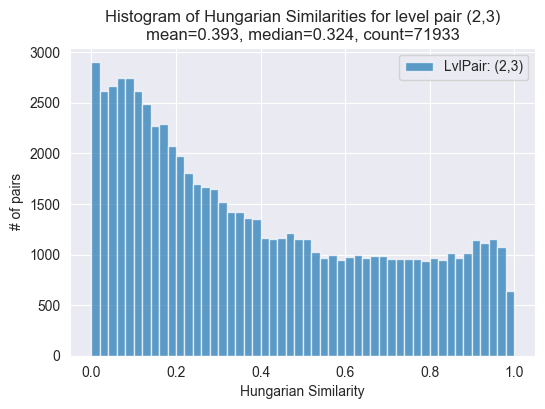

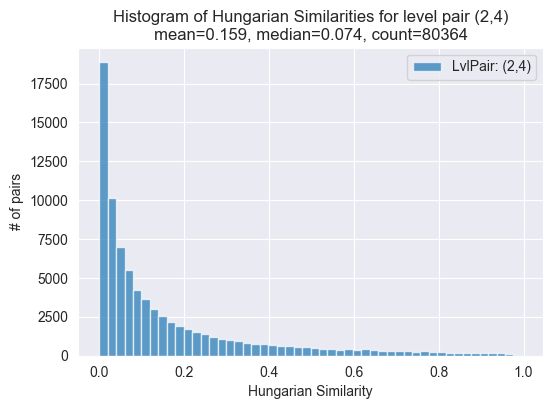

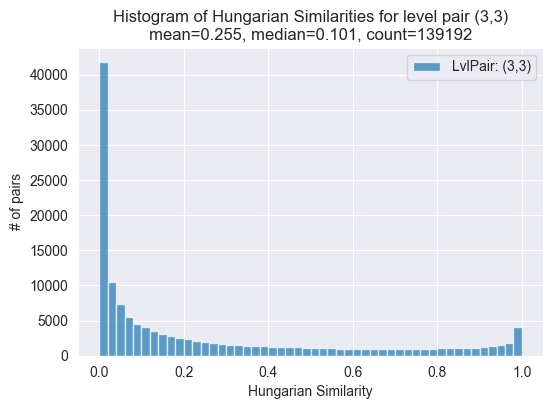

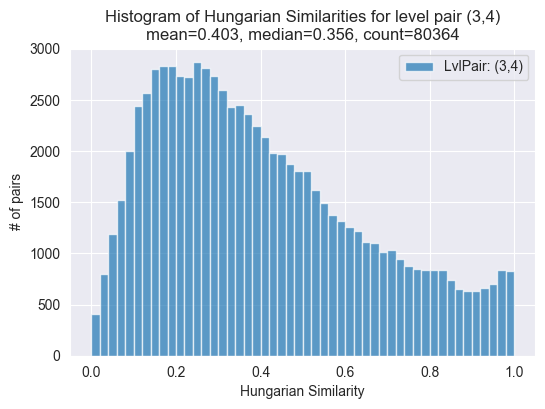

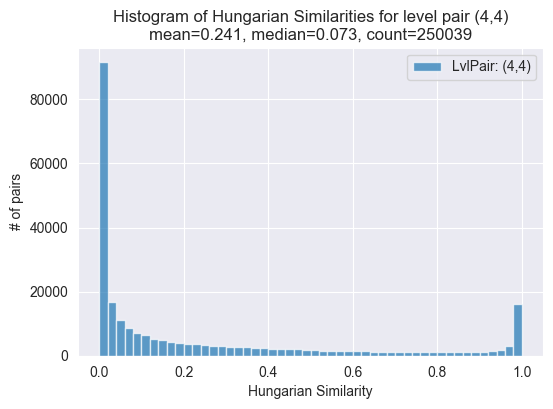

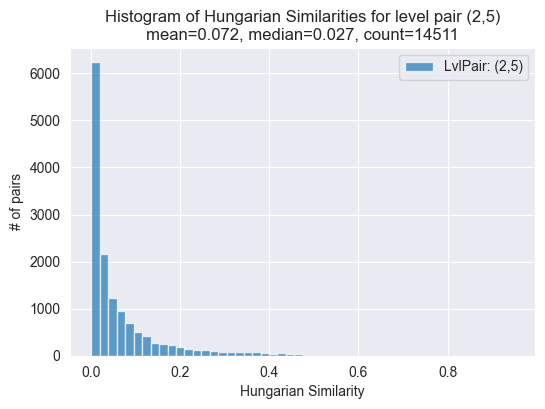

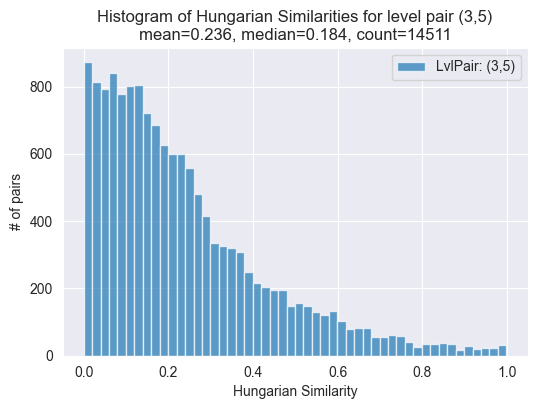

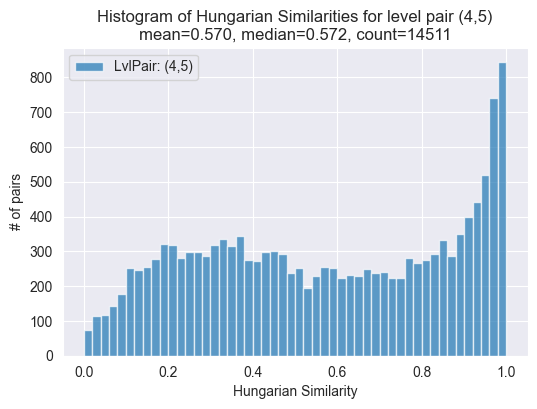

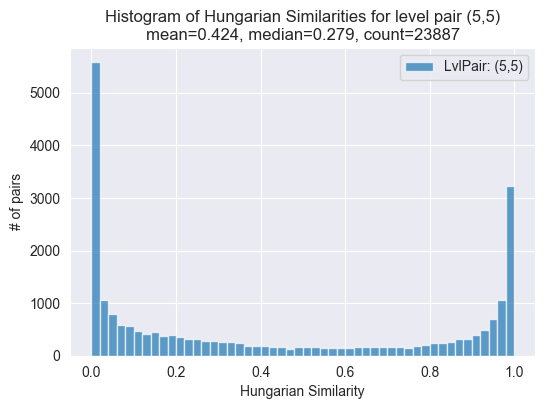

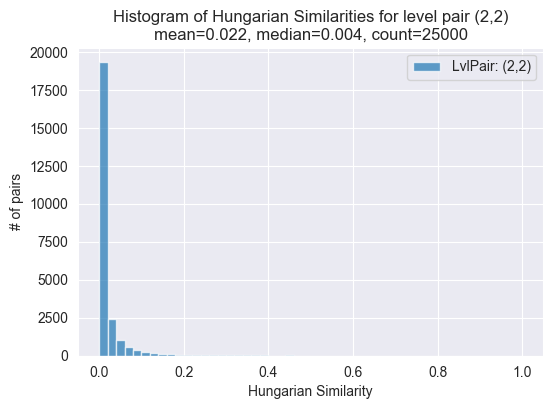

In [16]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims_hung, mode="Hungarian")

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_33726/54890244.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Level Pair", y="Similarity", data=df, palette="Set3")


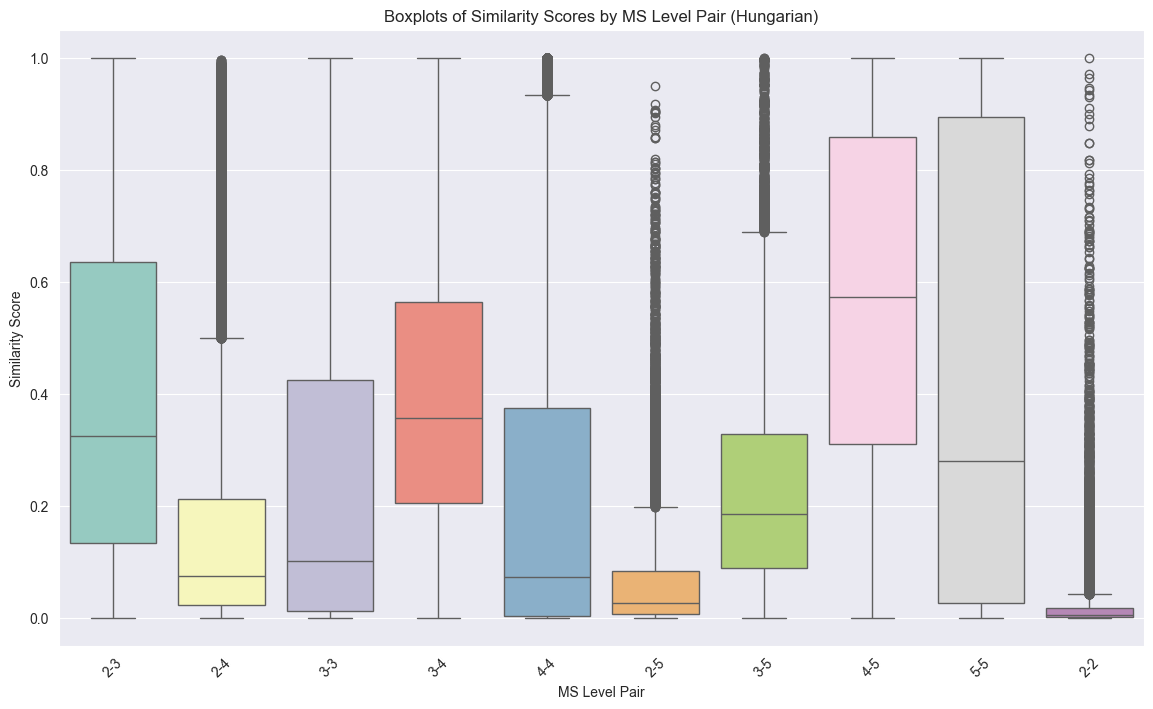

In [17]:
plot_boxplots(all_level_sims_hung, "Boxplots of Similarity Scores by MS Level Pair (Hungarian)")

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_33726/54890244.py:444: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_33726/54890244.py:444: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_33726/54890244.py:444: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_33726/54890244.py:444: FutureWarning: 

`shade` is now deprecated in favor of `fill`; 

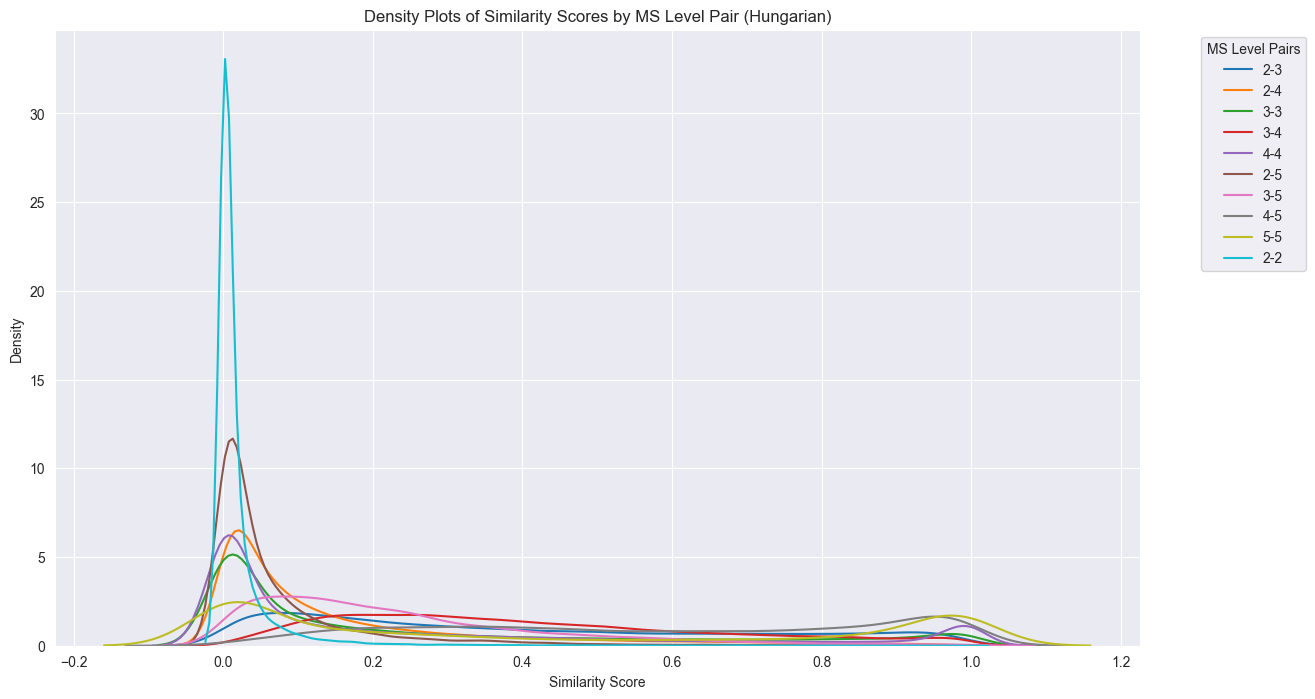

In [18]:
plot_density(all_level_sims_hung, "Density Plots of Similarity Scores by MS Level Pair (Hungarian)")

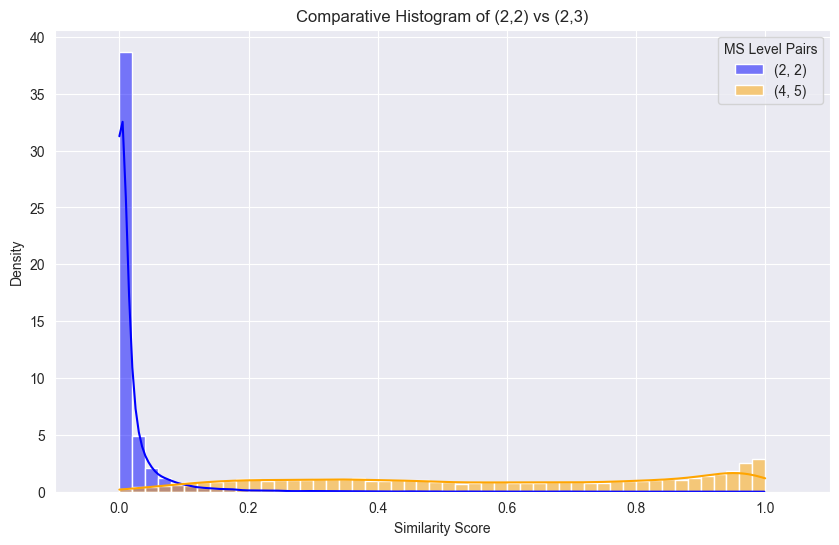

In [19]:
plot_comparative_histogram(all_level_sims_hung, (2, 2), (4, 5), "Comparative Histogram of (2,2) vs (2,3)")

In [20]:
# Generate the summary tables
ks_summary_df, aic_summary_df = summarize_all_level_pairs(all_level_sims_hung, top_n=5)

# Display KS Summary Table
print("\nTop 5 Best-Fitting Distributions Based on KS Statistic:")
display(ks_summary_df)

# Display AIC Summary Table
print("\nTop 5 Best-Fitting Distributions Based on AIC:")
display(aic_summary_df)


Fitting distributions for Level Pair (2, 3) with 71933 scores...

Fitting distributions for Level Pair (2, 4) with 80364 scores...

Fitting distributions for Level Pair (3, 3) with 139192 scores...

Fitting distributions for Level Pair (3, 4) with 80364 scores...

Fitting distributions for Level Pair (4, 4) with 250039 scores...

Fitting distributions for Level Pair (2, 5) with 14511 scores...

Fitting distributions for Level Pair (3, 5) with 14511 scores...

Fitting distributions for Level Pair (4, 5) with 14511 scores...

Fitting distributions for Level Pair (5, 5) with 23887 scores...

Fitting distributions for Level Pair (2, 2) with 25000 scores...

Top 5 Best-Fitting Distributions Based on KS Statistic:


,Distribution,Parameters,KS Statistic,KS p-value,Level Pair
0,beta,"(0.9529189668699778, 2.1430406223244924, -1.57...",0.047143,2.277159e-139,"2,3"
1,weibull_min,"(1.2124347883121667, -0.0008508629037633147, 0...",0.062610,1.398716e-245,"2,3"
2,gamma,"(1.247510526508711, -0.0007953053784309521, 0....",0.065866,9.182752e-272,"2,3"
3,lognorm,"(0.6717420620441968, -0.09993517911944097, 0.4...",0.071538,1.439707e-320,"2,3"
4,weibull_max,"(141373146.89470714, 32791666.38793264, 327916...",0.074026,0.000000e+00,"2,3"
5,weibull_min,"(0.7453535431238589, -1.0705943309842896e-30, ...",0.030777,1.436386e-66,"2,4"
6,pareto,"(2.002329621328352, -0.18230990420184898, 0.18...",0.049466,2.491512e-171,"2,4"
7,gamma,"(0.576079908061335, -5.4385845413828965e-31, 0...",0.063937,4.651442e-286,"2,4"
8,beta,"(0.46856270451909277, 2.495022325184895, -4.29...",0.080394,0.000000e+00,"2,4"
9,expon,"(0.0, 0.15920017039996986)",0.140059,0.000000e+00,"2,4"



Top 5 Best-Fitting Distributions Based on AIC:


,Distribution,Parameters,AIC,Level Pair
0,beta,"(0.9529189668699778, 2.1430406223244924, -1.57...",-3.654443e+03,"2,3"
1,uniform,"(0.0, 0.9995800041106572)",-5.643582e+01,"2,3"
2,weibull_min,"(1.2124347883121667, -0.0008508629037633147, 0...",6.175381e+03,"2,3"
3,gamma,"(1.247510526508711, -0.0007953053784309521, 0....",7.710433e+03,"2,3"
4,expon,"(0.0, 0.39291368614045286)",9.475372e+03,"2,3"
5,lognorm,"(119.93913359446574, -5e-324, 1.46519666918618...",-2.642031e+06,"2,4"
6,beta,"(0.46856270451909277, 2.495022325184895, -4.29...",-2.851602e+05,"2,4"
7,gamma,"(0.576079908061335, -5.4385845413828965e-31, 0...",-2.607937e+05,"2,4"
8,weibull_min,"(0.7453535431238589, -1.0705943309842896e-30, ...",-2.183247e+05,"2,4"
9,pareto,"(2.002329621328352, -0.18230990420184898, 0.18...",-1.441574e+05,"2,4"



Plotting Best-Fitting Distributions Based on KS Statistic:


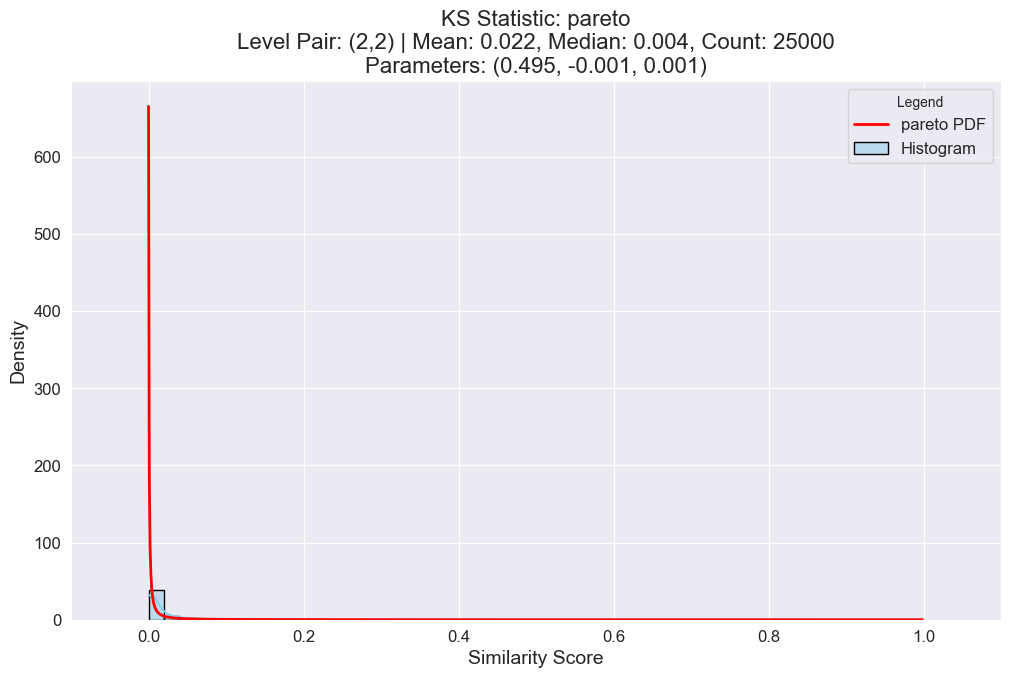

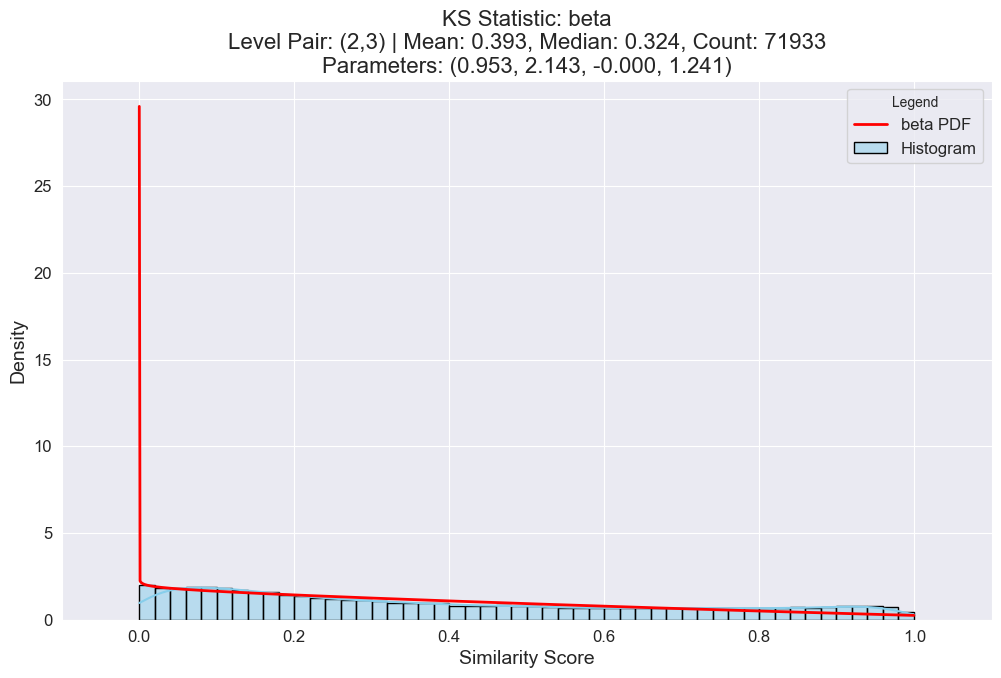

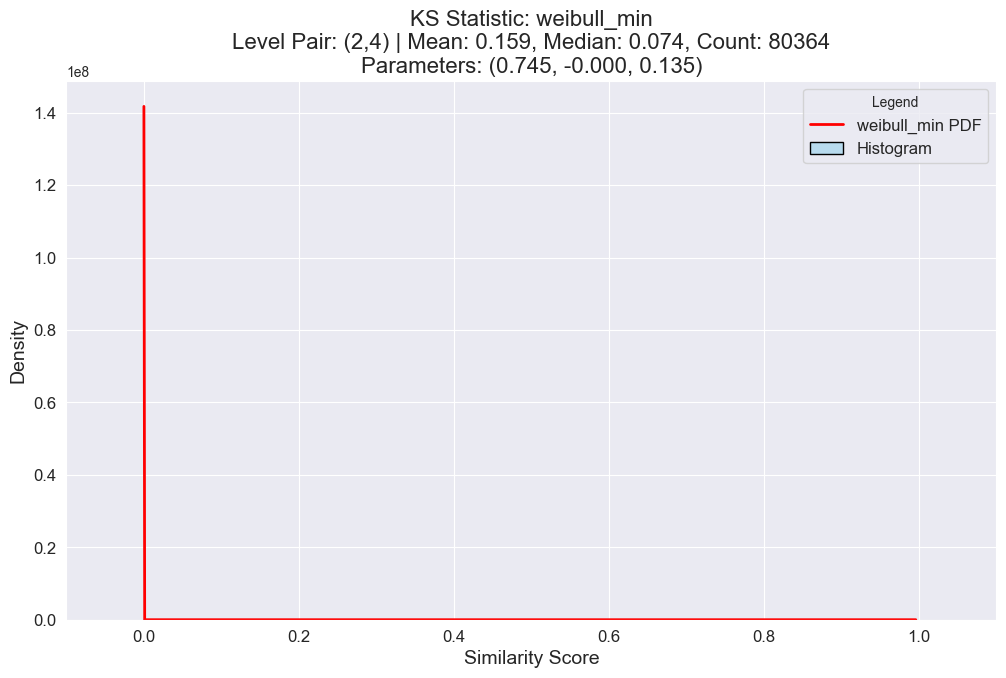

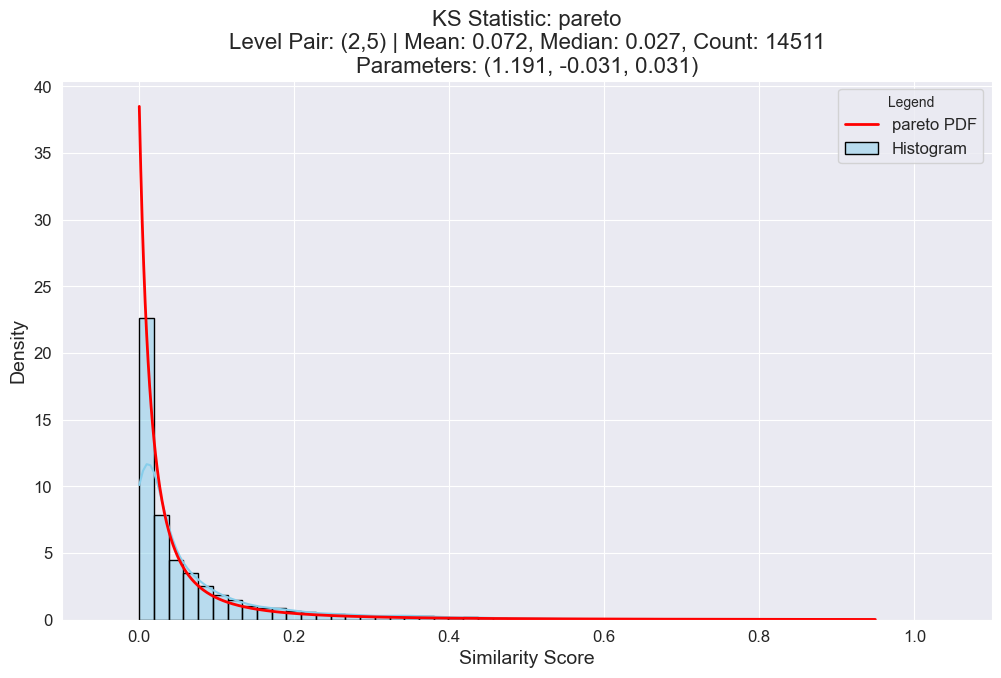

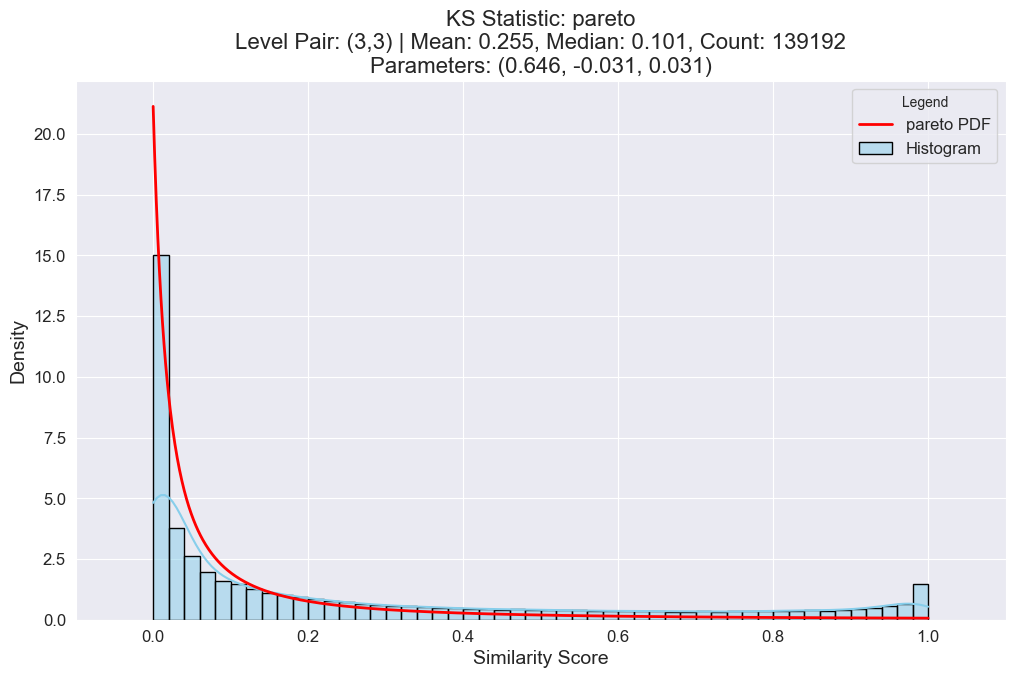

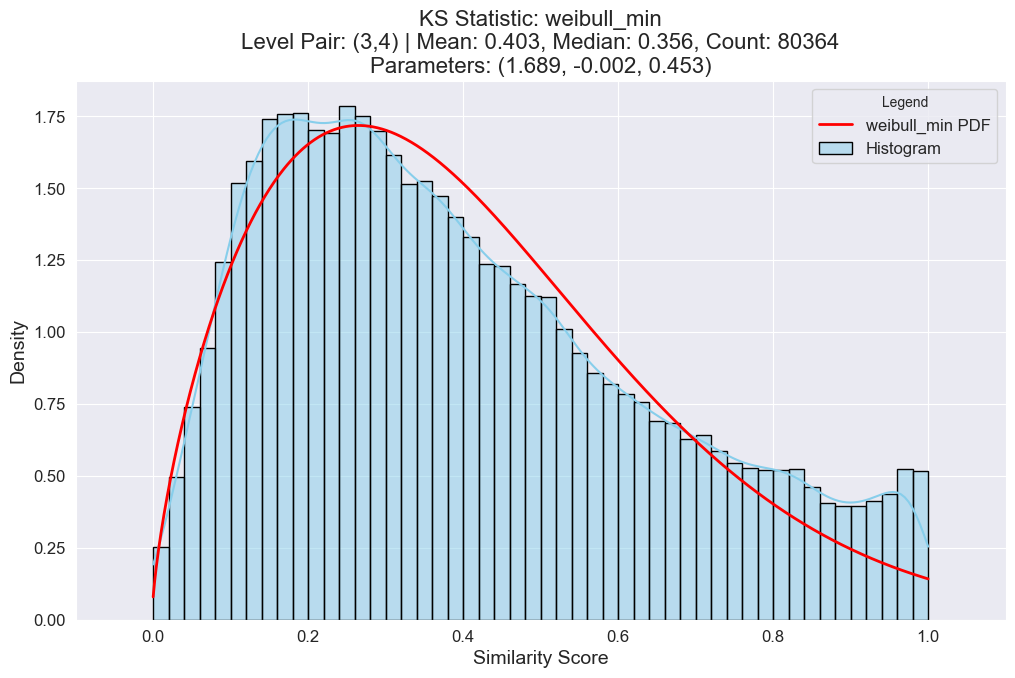

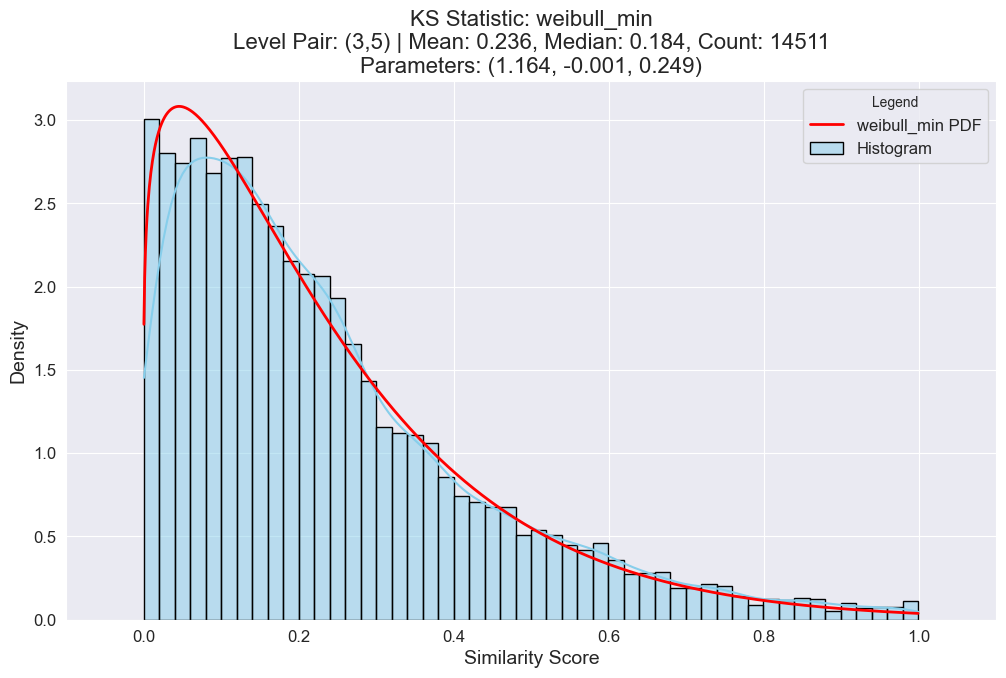

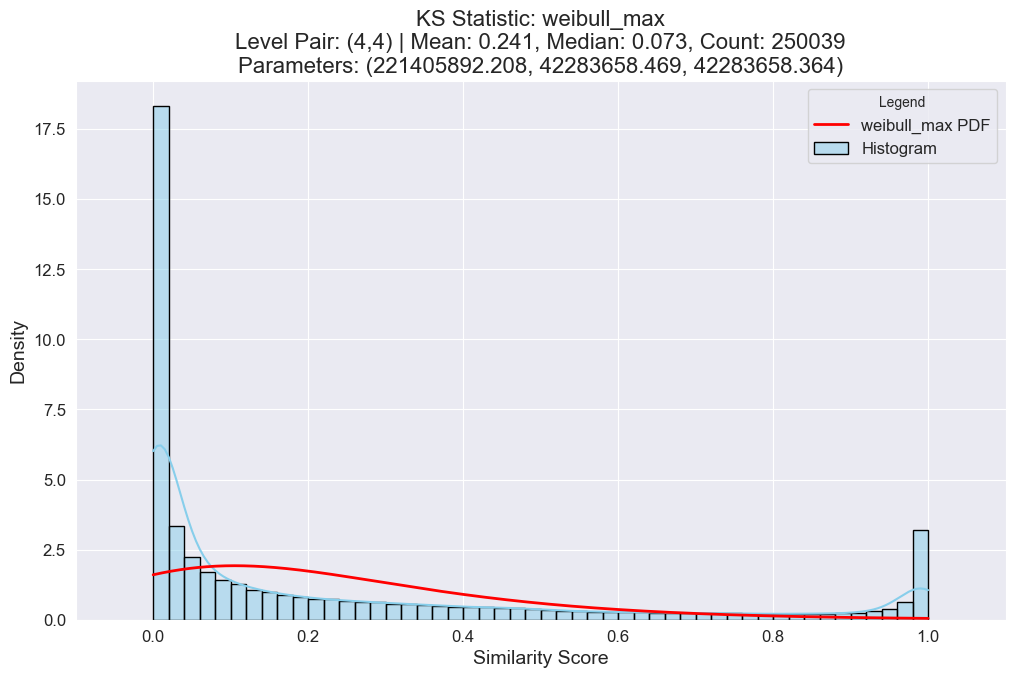

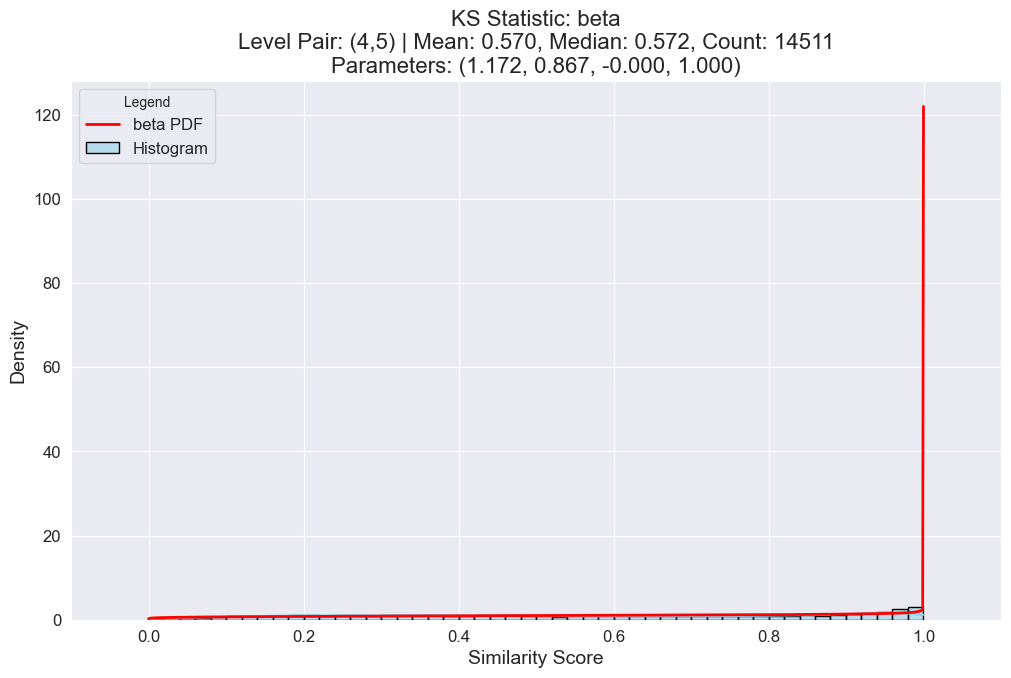

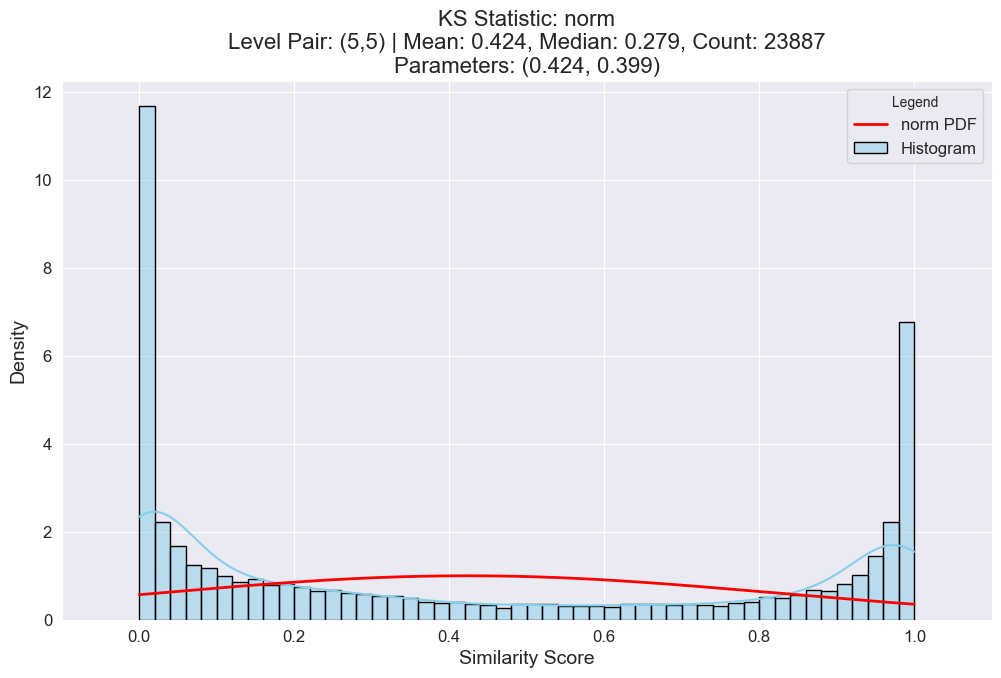

In [21]:
# Plotting Best-Fitting Distributions Based on KS Statistic
print("\nPlotting Best-Fitting Distributions Based on KS Statistic:")
plot_best_fit(
    summary_df=ks_summary_df,
    all_level_sims=all_level_sims_hung,
    criterion='KS Statistic',
    save_plots=False  # Set to True to save plots as PNG files
)


Plotting Best-Fitting Distributions Based on AIC:


/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


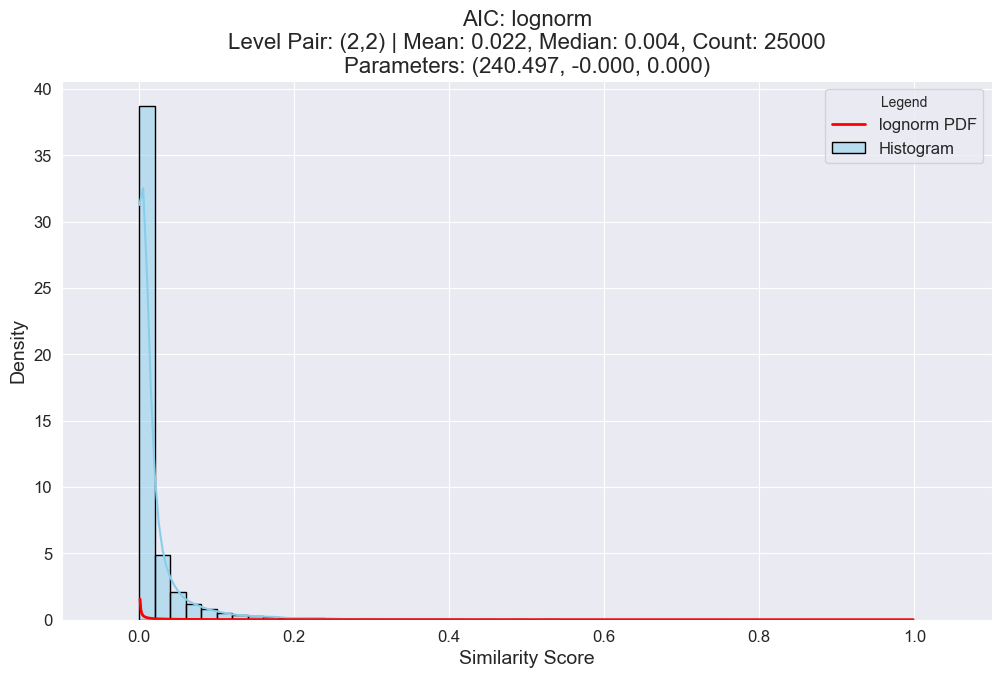

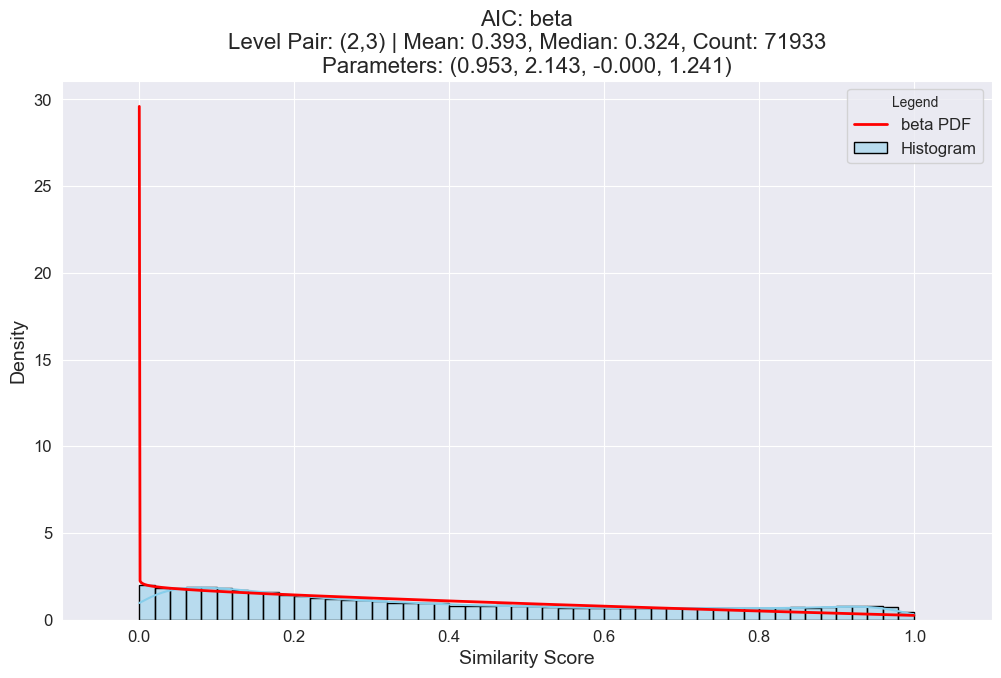

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


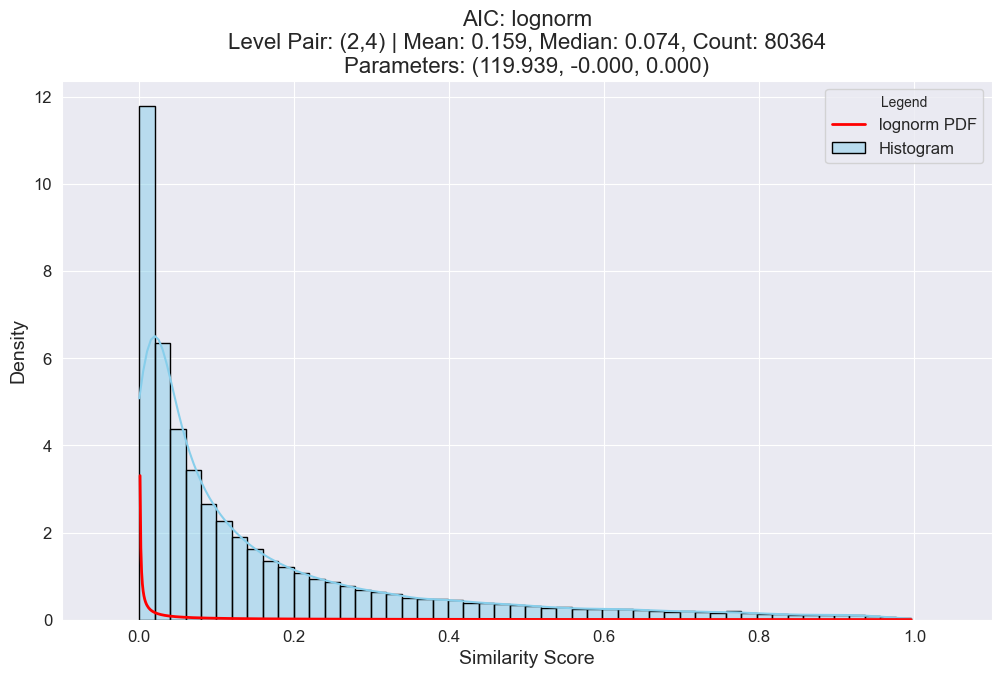

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


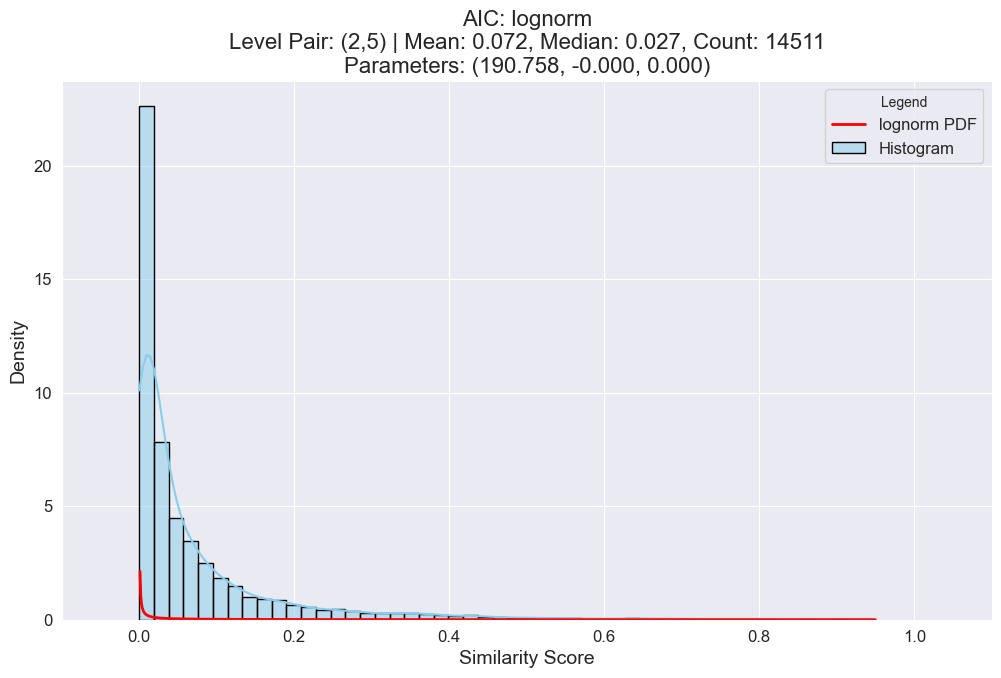

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


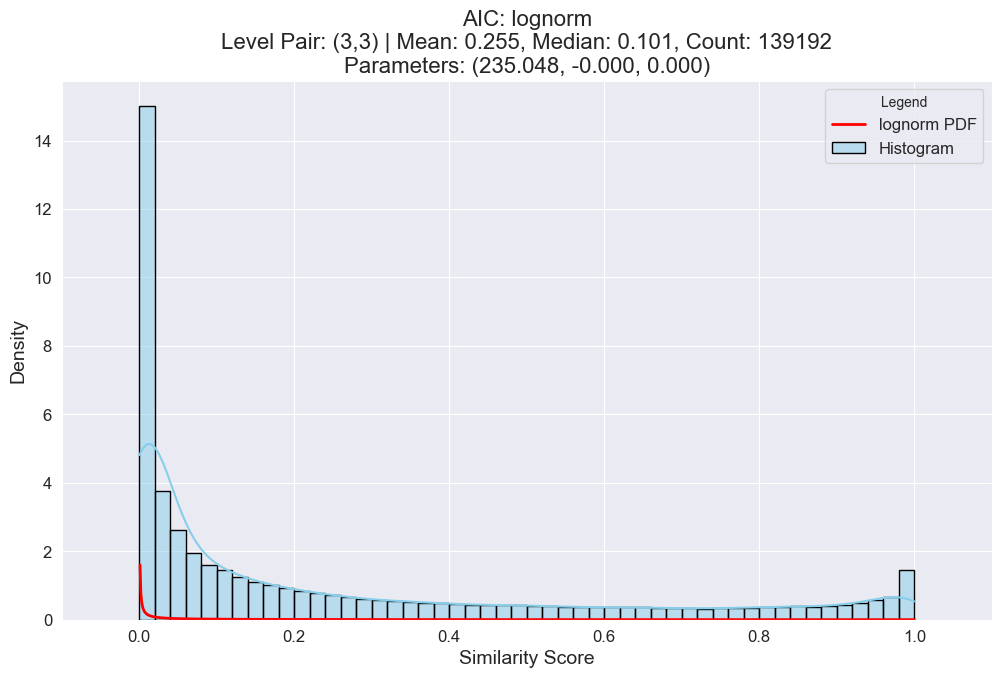

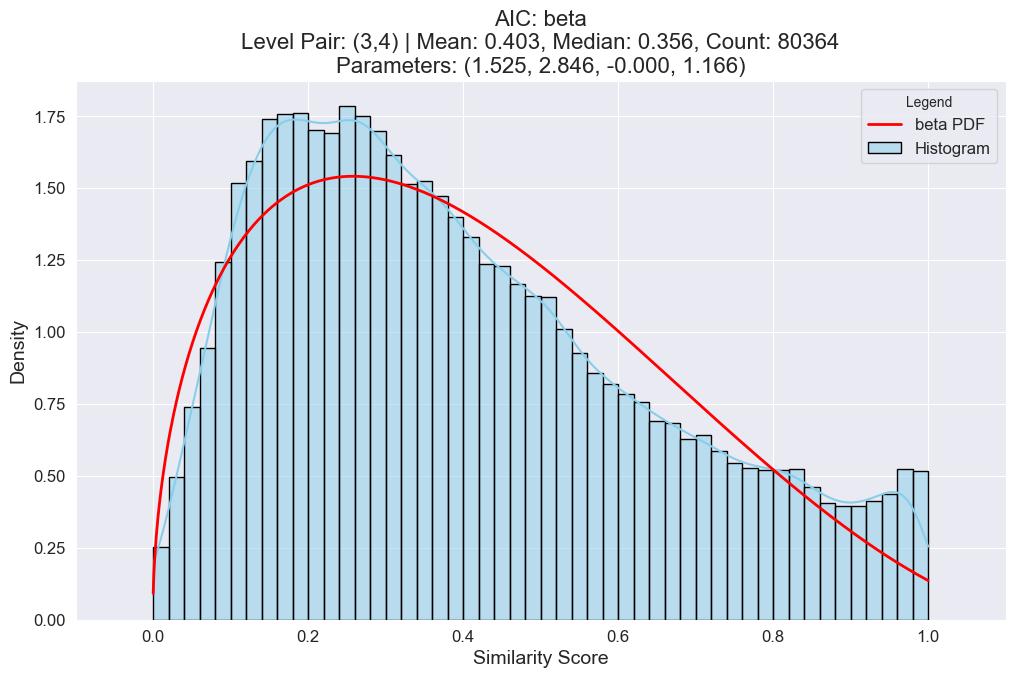

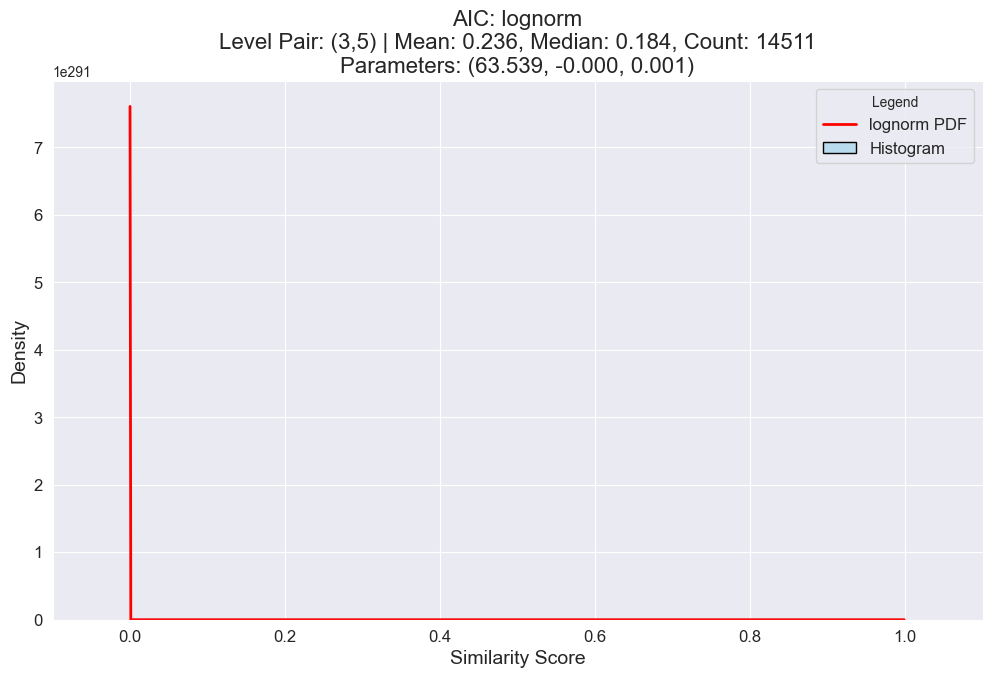

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


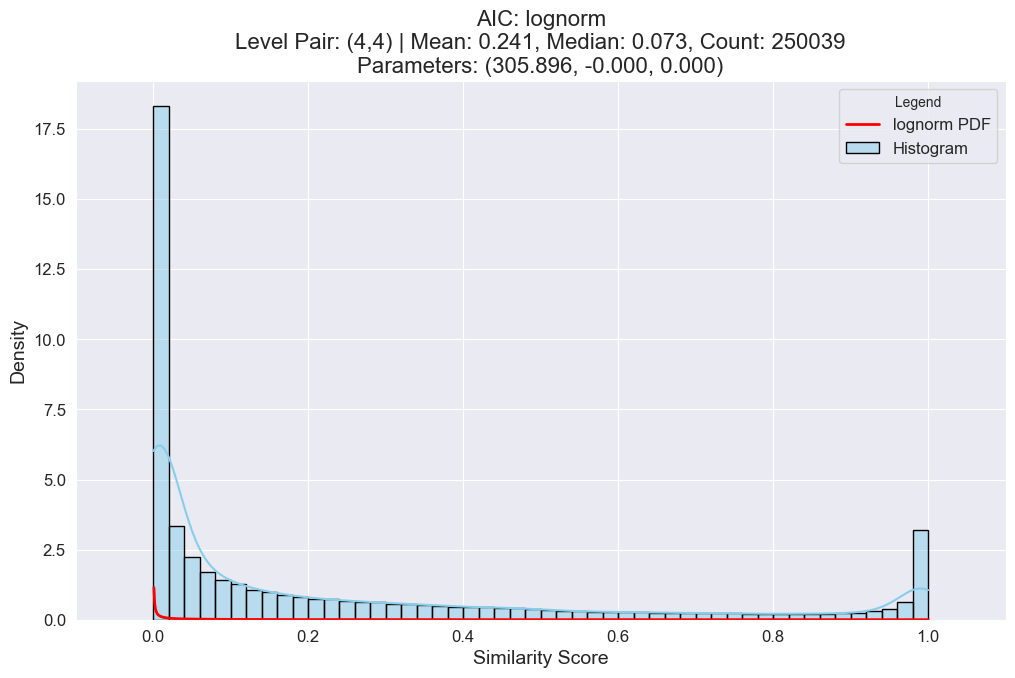

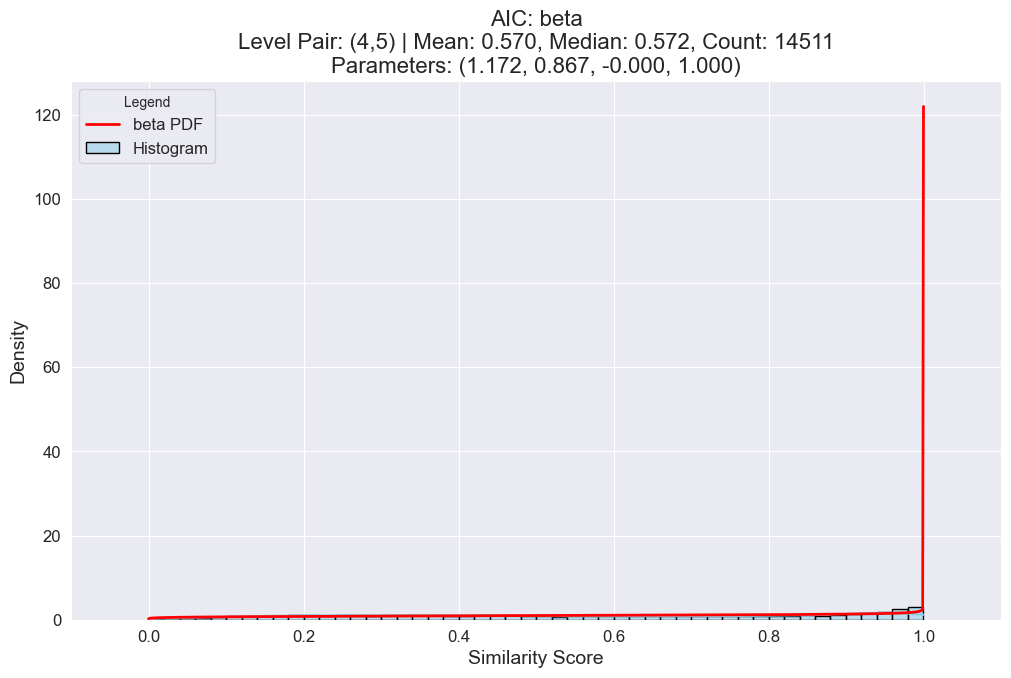

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


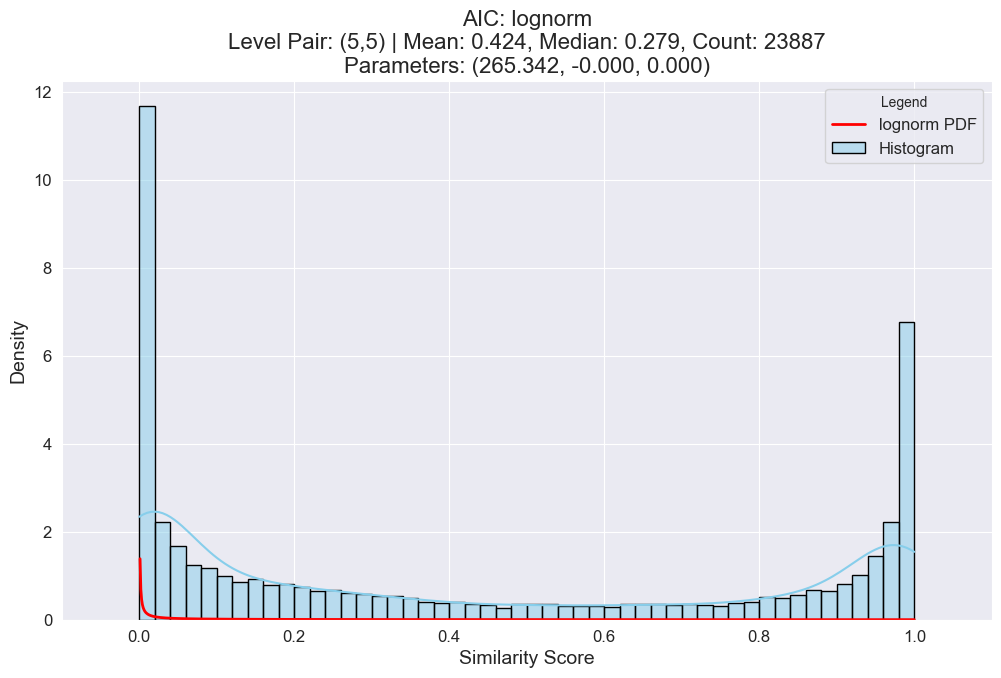

In [22]:
# Plotting Best-Fitting Distributions Based on AIC
print("\nPlotting Best-Fitting Distributions Based on AIC:")
plot_best_fit(
    summary_df=aic_summary_df,
    all_level_sims=all_level_sims_hung,
    criterion='AIC',
    save_plots=False  # Set to True to save plots as PNG files
)

### Sample 

In [23]:
sampled_all_level_sims = downsample_all_level_sims(all_level_sims_hung, random_seed=42)

Desired sample size per group set to the smallest group size: 14511
Downsampled group (2, 3) from 71933 to 14511
Downsampled group (2, 4) from 80364 to 14511
Downsampled group (3, 3) from 139192 to 14511
Downsampled group (3, 4) from 80364 to 14511
Downsampled group (4, 4) from 250039 to 14511
Group (2, 5) already has 14511 samples; no downsampling performed.
Group (3, 5) already has 14511 samples; no downsampling performed.
Group (4, 5) already has 14511 samples; no downsampling performed.
Downsampled group (5, 5) from 23887 to 14511
Downsampled group (2, 2) from 25000 to 14511


In [24]:
# Print average for each level pair
for level_pair, vals in sampled_all_level_sims.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.3895772785884555, 'std': 0.29461775191072426, 'median': 0.31892756927439475, 'count': 14511, 'q1': 0.12848130949789893, 'q3': 0.6295302092386197, 'IQR': 0.5010488997407208, 'range': 0.9981312036873685, 'skewness': 0.49964531955384306, 'kurtosis': -1.0301042455736054, 'ks_p': 1.8194388617331363e-144, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.1582080123453258, 'std': 0.20082681025069246, 'median': 0.07434581860799871, 'count': 14511, 'q1': 0.022355794538197436, 'q3': 0.21048808256223073, 'IQR': 0.18813228802403328, 'range': 0.9923296668872803, 'skewness': 1.8463712722566081, 'kurtosis': 2.993997996379102, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.25372780663116606, 'std': 0.3107297783603231, 'median': 0.10284145138636115, 'count': 14511, 'q1': 0.011136119664994962, 'q3': 0.4197091894084464, 'IQR': 0.4085730697434515, 'range': 0.9999735615914951, 'skewness': 1.1479251217540065, 'kurtosis': -0.035122993904764144, 'ks_p': 0.0,

In [25]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Sampled Hungarian Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(sampled_all_level_sims, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_hung)


--- Statistical Analysis for Sampled Hungarian Similarity Function ---
Group 1 Group 2           Test Used   Statistic       p-value  Adjusted Alpha  Significant  Effect Size          Effect Size Type
    2-3     2-4 Mann-Whitney U test 160369650.5  0.000000e+00        0.001111         True    -0.523202 Rank-Biserial Correlation
    4-5     2-2 Mann-Whitney U test 208117432.5  0.000000e+00        0.001111         True    -0.976714 Rank-Biserial Correlation
    3-3     2-2 Mann-Whitney U test 162924190.5  0.000000e+00        0.001111         True    -0.547465 Rank-Biserial Correlation
    3-4     4-4 Mann-Whitney U test 152822562.0  0.000000e+00        0.001111         True    -0.451519 Rank-Biserial Correlation
    3-4     2-5 Mann-Whitney U test 195131602.0  0.000000e+00        0.001111         True    -0.853373 Rank-Biserial Correlation
    3-4     3-5 Mann-Whitney U test 149576690.0  0.000000e+00        0.001111         True    -0.420690 Rank-Biserial Correlation
    3-4     4-5 Ma

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_33726/54890244.py:444: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_33726/54890244.py:444: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_33726/54890244.py:444: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_33726/54890244.py:444: FutureWarning: 

`shade` is now deprecated in favor of `fill`; 

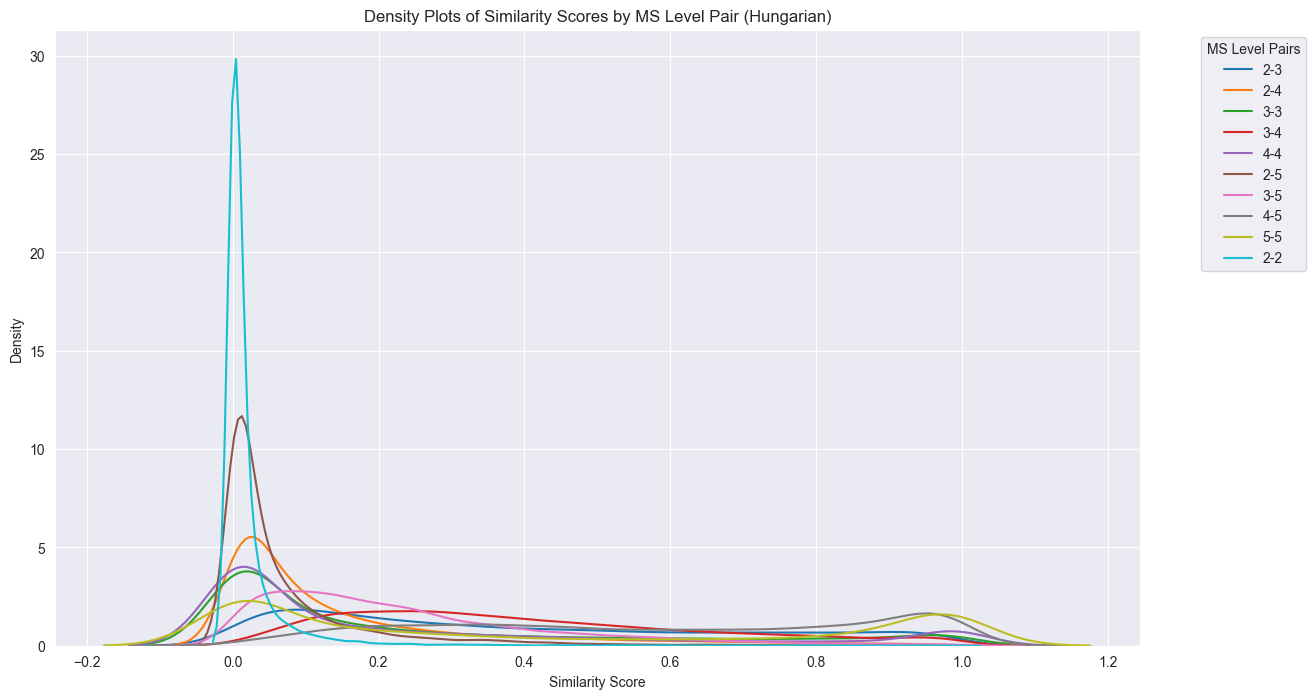

In [26]:
plot_density(sampled_all_level_sims, "Density Plots of Similarity Scores by MS Level Pair (Hungarian)")

## Correlation

,Level_A,Level_B,Similarity_Score,Avg_Level,Level_Difference,Level_Pair
0,2,3,0.950707,2.5,1,"2,3"
1,2,3,0.540661,2.5,1,"2,3"
2,2,3,0.175046,2.5,1,"2,3"
3,2,3,0.830678,2.5,1,"2,3"
4,2,3,0.082853,2.5,1,"2,3"


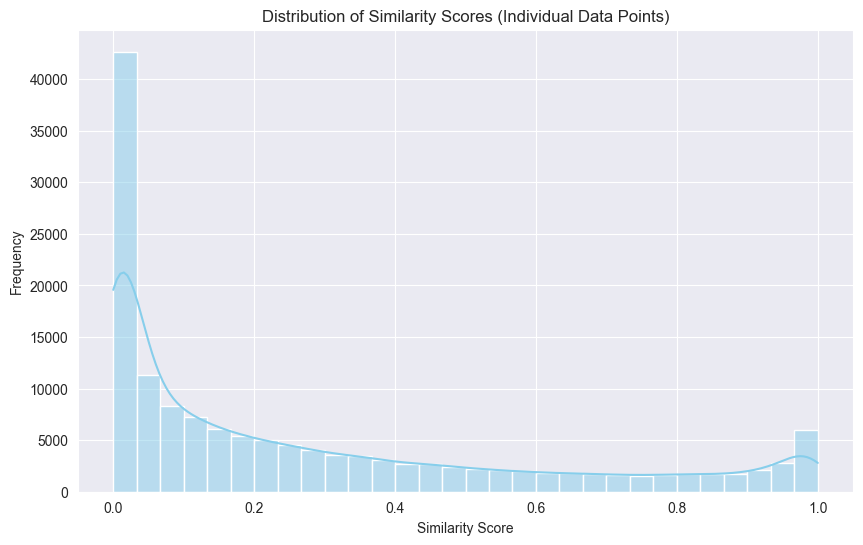

Skewness of Similarity_Score: 1.046
Applied log transformation to Similarity_Score.
Skewness after log transformation: 0.814


In [27]:
data = []
for level_pair, sims in sampled_all_level_sims.items():
    lvlA, lvlB = level_pair
    for sim in sims:
        data.append({
            'Level_A': lvlA,
            'Level_B': lvlB,
            'Similarity_Score': sim
        })

df = pd.DataFrame(data)

# Compute Avg_Level and Level_Difference
df['Avg_Level'] = df[['Level_A', 'Level_B']].mean(axis=1)
df['Level_Difference'] = abs(df['Level_A'] - df['Level_B'])

# Create a categorical variable for Level_Pair
df['Level_Pair'] = df.apply(lambda row: f"{int(row['Level_A'])},{int(row['Level_B'])}", axis=1)

# Display the first few rows
display(df.head())

# Group by Level Pair and compute descriptive statistics
grouped = df.groupby(['Level_A', 'Level_B'])

# Compute mean, median, std, and count similarity scores
stats_df = grouped['Similarity_Score'].agg(['mean', 'median', 'std', 'count']).reset_index()
stats_df.rename(columns={
    'mean': 'Mean_Similarity',
    'median': 'Median_Similarity',
    'std': 'Std_Similarity',
    'count': 'Count'
}, inplace=True)

# Compute additional hierarchy metrics
stats_df['Avg_Level'] = stats_df[['Level_A', 'Level_B']].mean(axis=1)
stats_df['Level_Difference'] = abs(stats_df['Level_A'] - stats_df['Level_B'])

# Optional: Plot the distribution of Similarity_Score
plt.figure(figsize=(10, 6))
sns.histplot(df['Similarity_Score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Similarity Scores (Individual Data Points)')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

# Check for skewness
skewness = df['Similarity_Score'].skew()
print(f"Skewness of Similarity_Score: {skewness:.3f}")

# If skewness is significant (e.g., |skewness| > 1),
if abs(skewness) > 1:
    df['Similarity_Score_Log'] = np.log(df['Similarity_Score'] + 1)  # Adding 1 to handle zero or negative values
    print("Applied log transformation to Similarity_Score.")

    skewness_log = df['Similarity_Score_Log'].skew()
    print(f"Skewness after log transformation: {skewness_log:.3f}")
    
    # Use the transformed variable in regression
    dependent_var = 'Similarity_Score_Log'
else:
    dependent_var = 'Similarity_Score'

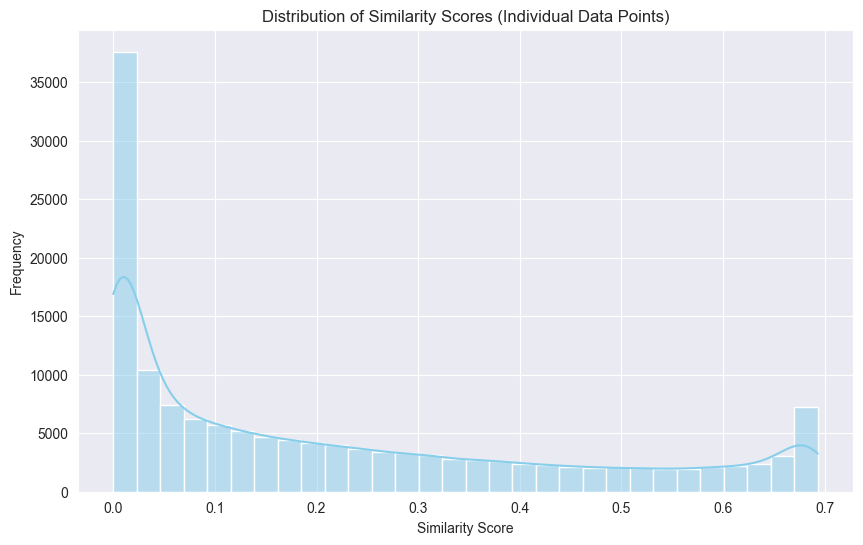

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Similarity_Score_Log'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Similarity Scores (Individual Data Points)')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

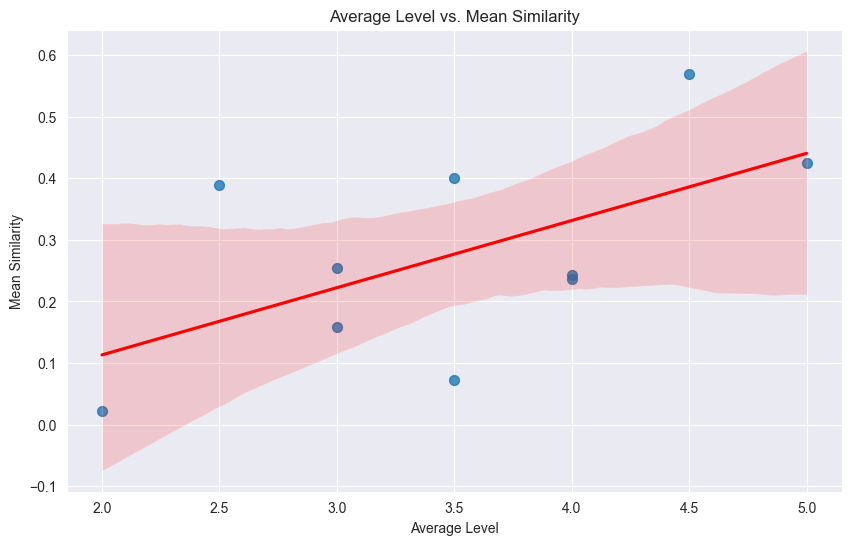

In [29]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Avg_Level', y='Mean_Similarity', data=stats_df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Average Level vs. Mean Similarity')
plt.xlabel('Average Level')
plt.ylabel('Mean Similarity')
plt.show()

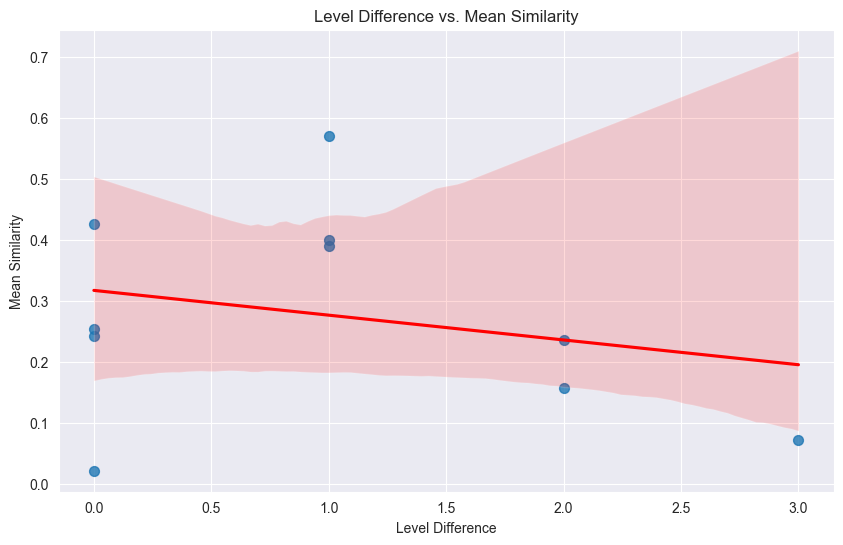

In [30]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Level_Difference', y='Mean_Similarity', data=stats_df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Level Difference vs. Mean Similarity')
plt.xlabel('Level Difference')
plt.ylabel('Mean Similarity')
plt.show()

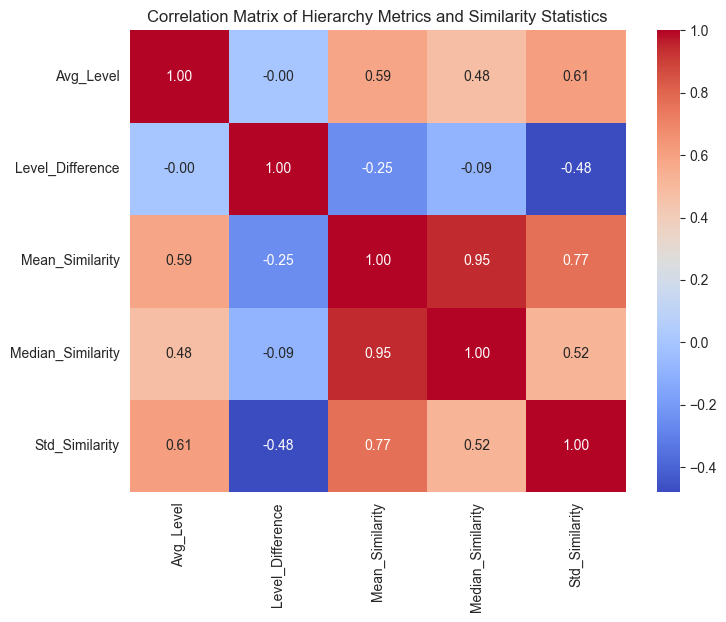

In [31]:
# Heatmap of Correlation Matrix
corr_matrix = stats_df[['Avg_Level', 'Level_Difference', 'Mean_Similarity', 'Median_Similarity', 'Std_Similarity']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Hierarchy Metrics and Similarity Statistics')
plt.show()

In [32]:
# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(stats_df['Avg_Level'], stats_df['Mean_Similarity'])
print(f"Spearman Correlation between Avg_Level and Mean_Similarity: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")

Spearman Correlation between Avg_Level and Mean_Similarity: 0.569
P-value: 0.086



In [33]:
# Spearman correlation between Avg_Level and Similarity_Score
spearman_corr, spearman_p = stats.spearmanr(df['Avg_Level'], df['Similarity_Score'])
print(f"Spearman Correlation between Avg_Level and Similarity_Score: {spearman_corr:.3f}")
print(f"P-value: {spearman_p:.3f}")

Spearman Correlation between Avg_Level and Similarity_Score: 0.295
P-value: 0.000


In [34]:
# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(stats_df['Level_Difference'], stats_df['Mean_Similarity'])
print(f"Spearman Correlation between Level_Difference and Mean_Similarity: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")

Spearman Correlation between Level_Difference and Mean_Similarity: -0.261
P-value: 0.467



In [35]:
# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(df['Level_Difference'], df['Similarity_Score'])
print(f"Spearman Correlation between Level_Difference and Similarity_Score: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")

Spearman Correlation between Level_Difference and Similarity_Score: 0.042
P-value: 0.000



In [36]:
# ===========================
# 4. Regression Analysis on Individual Data
# ===========================

# Simple Linear Regression: Similarity_Score ~ Avg_Level
X = sm.add_constant(df['Avg_Level'])
y = df[dependent_var]

model = sm.OLS(y, X).fit()
print("Simple Linear Regression: Similarity_Score ~ Avg_Level")
print(model.summary())

# Multiple Linear Regression: Similarity_Score ~ Avg_Level + Level_Difference
X_multi = sm.add_constant(df[['Avg_Level', 'Level_Difference']])
y_multi = df[dependent_var]

model_multi = sm.OLS(y_multi, X_multi).fit()
print("\nMultiple Linear Regression: Similarity_Score ~ Avg_Level + Level_Difference")
print(model_multi.summary())

Simple Linear Regression: Similarity_Score ~ Avg_Level
                             OLS Regression Results                             
Dep. Variable:     Similarity_Score_Log   R-squared:                       0.096
Model:                              OLS   Adj. R-squared:                  0.096
Method:                   Least Squares   F-statistic:                 1.536e+04
Date:                  Tue, 31 Dec 2024   Prob (F-statistic):               0.00
Time:                          20:16:01   Log-Likelihood:                 19742.
No. Observations:                145110   AIC:                        -3.948e+04
Df Residuals:                    145108   BIC:                        -3.946e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

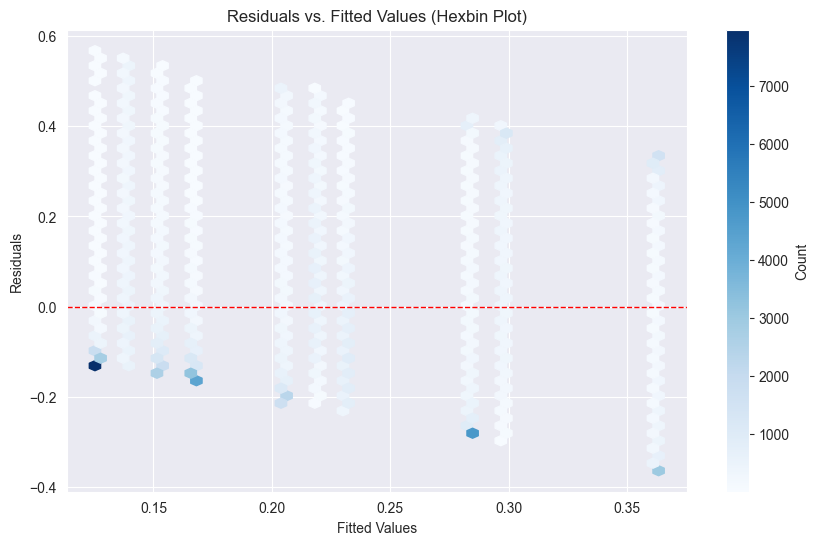

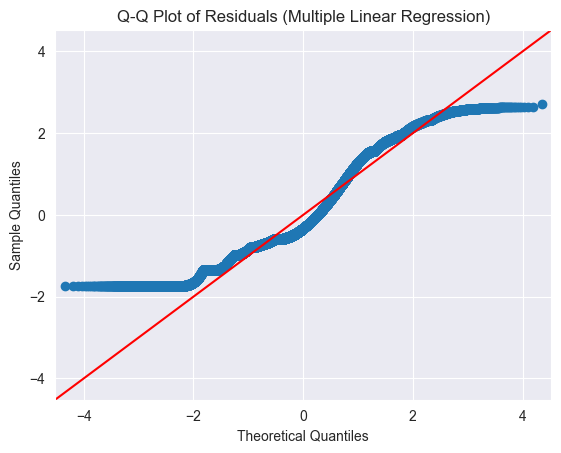

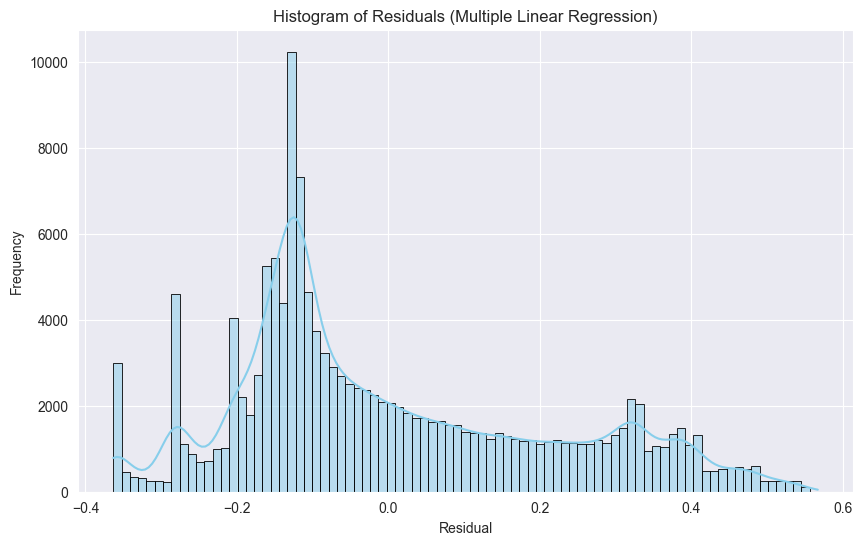

In [37]:

# ===========================
# 5. Assessing Model Assumptions
# ===========================

# Residuals vs. Fitted Values
# 	•	Homogeneity of Variance: The spread of residuals should be consistent across all levels of fitted values.
# 	•	No Patterns: Residuals should be randomly scattered without discernible patterns, indicating linearity.
# Residuals vs. Fitted Values using Hexbin Plot
plt.figure(figsize=(10, 6))
plt.hexbin(model_multi.fittedvalues, model_multi.resid, gridsize=50, cmap='Blues', mincnt=1)
cb = plt.colorbar(label='Count')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values (Hexbin Plot)')
plt.show()

# Q-Q Plot for Normality of Residuals
# Normality: Points should lie approximately along the 45-degree line, suggesting that residuals are normally distributed.
sm.qqplot(model_multi.resid, line='45', fit=True,)
plt.title('Q-Q Plot of Residuals (Multiple Linear Regression)')
plt.show()

# Histogram of Residuals
# 	•	Symmetry: The histogram should be symmetric around zero.
# 	•	KDE Overlay: The Kernel Density Estimate should resemble a normal distribution.
plt.figure(figsize=(10, 6))
sns.histplot(model_multi.resid, kde=True, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals (Multiple Linear Regression)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

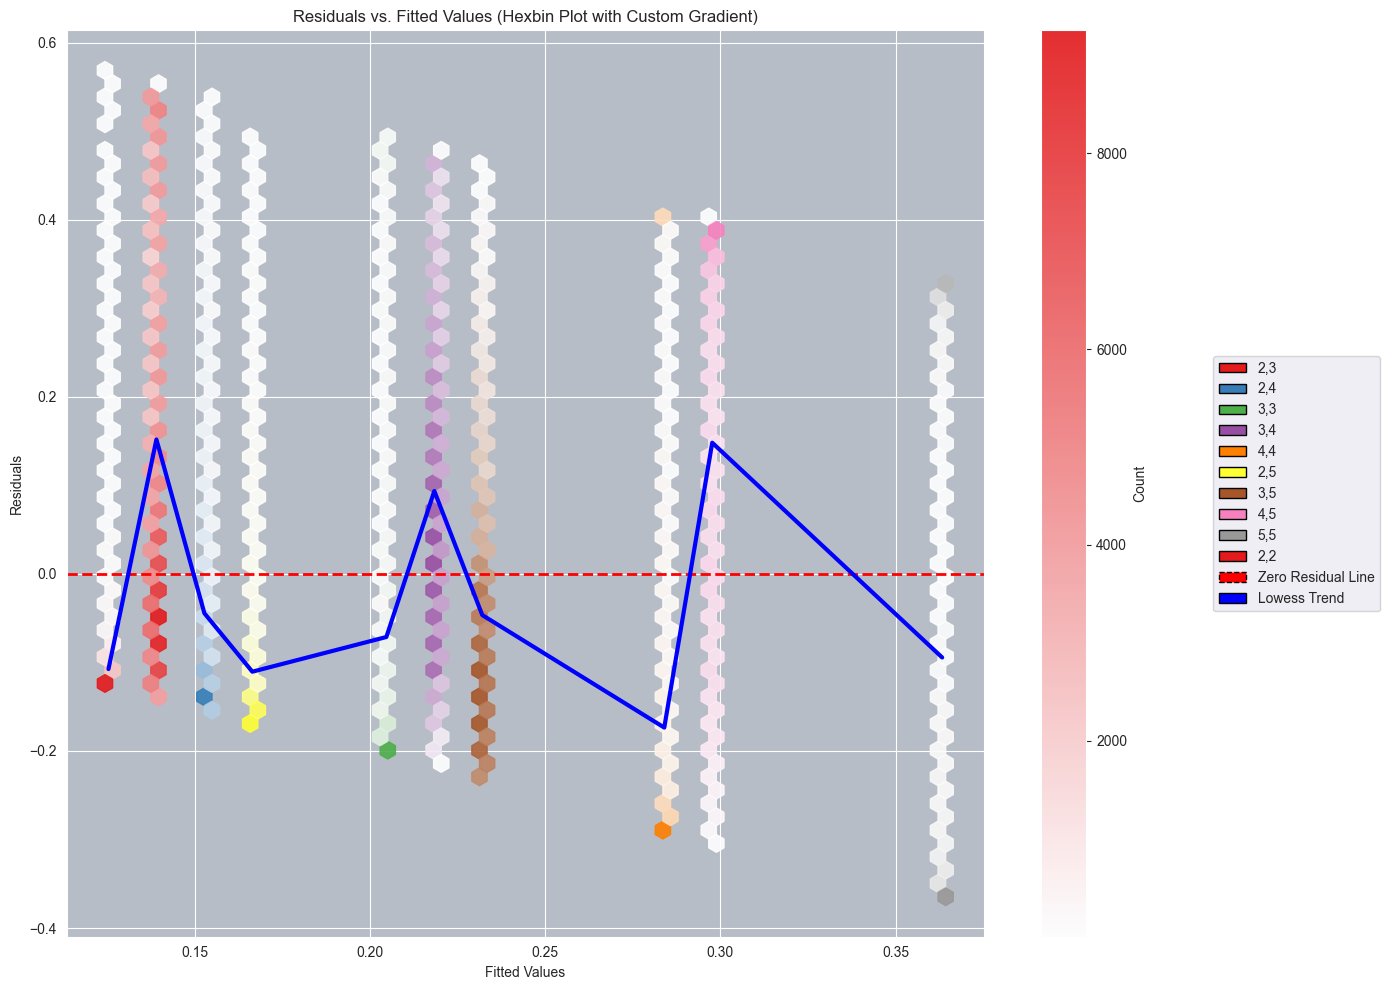

In [38]:
# Get unique Level_Pair groups
level_pairs = df['Level_Pair'].unique()
num_groups = len(level_pairs)

# Choose a high-contrast color palette
colors = sns.color_palette('Set1', n_colors=num_groups)  # High-contrast palette

# Set a darker background for better visibility
plt.figure(figsize=(14, 10))
plt.gca().set_facecolor('#b7bdc7')  # Light gray background

# Determine axis limits with padding
x_min = model_multi.fittedvalues.min() - 0.05 * (model_multi.fittedvalues.max() - model_multi.fittedvalues.min())
x_max = model_multi.fittedvalues.max() + 0.05 * (model_multi.fittedvalues.max() - model_multi.fittedvalues.min())
y_min = model_multi.resid.min() - 0.05 * (model_multi.resid.max() - model_multi.resid.min())
y_max = model_multi.resid.max() + 0.05 * (model_multi.resid.max() - model_multi.resid.min())

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Loop through each group and plot its hexbin
for i, (group, color) in enumerate(zip(level_pairs, colors)):
    subset = df[df['Level_Pair'] == group]
    
    # Extract fitted values and residuals for the subset
    subset_fitted = model_multi.fittedvalues.loc[subset.index]
    subset_resid = model_multi.resid.loc[subset.index]
    
    # Create a custom colormap from white to the group color
    cmap = LinearSegmentedColormap.from_list(f'custom_cmap_{i}', ['white', color])
    
    # Generate hexbin
    hb = plt.hexbin(
        subset_fitted, 
        subset_resid, 
        gridsize=60,  # Smaller bins for better separation
        extent=(x_min, x_max, y_min, y_max),  # Ensure uniform bin size across the plot
        cmap=cmap, 
        alpha=0.9, 
        mincnt=1, 
        label=group
    )
    
    # Draw black borders for hexagons
    vertices = hb.get_offsets()
    for offset, count in zip(vertices, hb.get_array()):
        if count > 0:  # Draw only for populated bins
            hexagon = hb.get_paths()[0].transformed(hb.get_transform())
            plt.gca().add_patch(Polygon(hexagon.vertices + offset, edgecolor='black', fill=False, linewidth=0.5))

# Add a single colorbar for the last hexbin plotted
plt.colorbar(hb, label='Count')  

# Add a horizontal line at residual = 0 for reference
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')

# Calculate Lowess trend and make the line thicker
lowess_smoothed = lowess(model_multi.resid, model_multi.fittedvalues, frac=0.3)
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='blue', linestyle='-', linewidth=3, label='Lowess Trend')

# Customize labels and title
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values (Hexbin Plot with Custom Gradient)')

# Create custom legend with aligned colors
legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=group) 
                   for i, group in enumerate(level_pairs)]
legend_elements.append(Patch(facecolor='red', edgecolor='black', label='Zero Residual Line', linestyle='--'))
legend_elements.append(Patch(facecolor='blue', edgecolor='black', label='Lowess Trend'))

# Adjust legend position to avoid overlap and ensure alignment
plt.legend(handles=legend_elements, bbox_to_anchor=(1.25, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## inter group investigation

In [39]:
warnings.filterwarnings('ignore')
# Filter intergroup data
intergroup_pairs = [(2,2), (3,3), (4,4), (5,5)]
intergroup_df = df[df['Level_Pair'].isin([f"{a},{b}" for a,b in intergroup_pairs])].copy()

# Ensure 'Level_Pair' is categorical
intergroup_df['Level_Pair'] = intergroup_df['Level_Pair'].astype('category')

# Check for NaNs and remove if any
intergroup_df = intergroup_df.dropna(subset=['Similarity_Score'])

# Perform Kruskal-Wallis H-test
groups = intergroup_df.groupby('Level_Pair')['Similarity_Score'].apply(list)

stat, p = kruskal(*groups)
print("Kruskal-Wallis H-test for Intergroup Comparison:")
print(f"Statistic: {stat:.3f}, p-value: {p:.3f}\n")

Kruskal-Wallis H-test for Intergroup Comparison:
Statistic: 10278.553, p-value: 0.000



In [40]:
# Get unique groups
groups = intergroup_df.groupby('Level_Pair')['Similarity_Score'].apply(list)

# Get all pairwise combinations
pairwise = list(combinations(groups.index, 2))

results = []
p_values = []

for g1, g2 in pairwise:
    stat, p = stats.mannwhitneyu(groups[g1], groups[g2], alternative='two-sided')
    results.append((g1, g2, stat, p))
    p_values.append(p)

# Adjust p-values for multiple comparisons using Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Compile results
comparison_results = []
for i, (g1, g2, stat, p) in enumerate(results):
    comparison_results.append({
        "Group 1": g1,
        "Group 2": g2,
        "Statistic": stat,
        "p-value": p,
        "p-value Adjusted": pvals_corrected[i],
        "Significant": reject[i]
    })

comparison_df = pd.DataFrame(comparison_results)

print("Pairwise Mann-Whitney U Test with Bonferroni Correction:")
print(comparison_df)

Pairwise Mann-Whitney U Test with Bonferroni Correction:
  Group 1 Group 2    Statistic        p-value  p-value Adjusted  Significant
0     2,2     3,3   47644930.5   0.000000e+00      0.000000e+00         True
1     2,2     4,4   62011084.5   0.000000e+00      0.000000e+00         True
2     2,2     5,5   41462262.5   0.000000e+00      0.000000e+00         True
3     3,3     4,4  112660555.5   3.826917e-25      2.296150e-24         True
4     3,3     5,5   82679928.5  1.088153e-220     6.528918e-220         True
5     4,4     5,5   78983894.5  3.742394e-299     2.245437e-298         True


In [42]:
intergroup_df['Hierarchy_Level'] = intergroup_df['Level_Pair'].apply(lambda x: int(x.split(',')[0]))

# Calculate summary statistics
summary_df = intergroup_df.groupby('Hierarchy_Level')['Similarity_Score'].agg(['mean', 'median', 'std', 'count']).reset_index()
print("Summary Statistics by Hierarchy Level:")
print(summary_df)

Summary Statistics by Hierarchy Level:
  Hierarchy_Level      mean    median       std  count
0               2  0.022219  0.004299  0.061574  14511
1               3  0.253728  0.102841  0.310740  14511
2               4  0.242289  0.075179  0.322675  14511
3               5  0.425280  0.280398  0.399463  14511


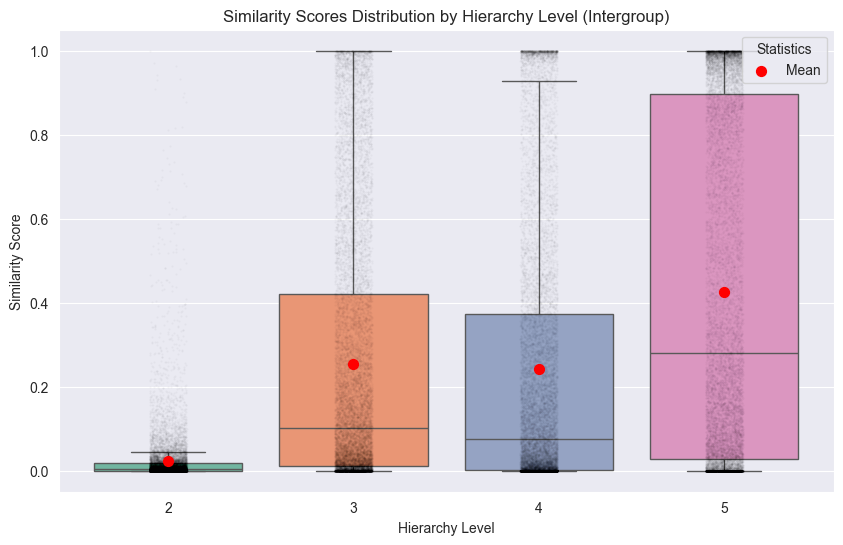

In [43]:
plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(
    x='Hierarchy_Level', 
    y='Similarity_Score', 
    data=intergroup_df, 
    palette='Set2', 
    showfliers=False  # Suppress default outliers
)

# Add outliers separately for customization
sns.stripplot(
    x='Hierarchy_Level', 
    y='Similarity_Score', 
    data=intergroup_df, 
    color='black', 
    alpha=0.03,  # Slightly more opaque for better visibility
    jitter=True, 
    size=1.45
)

# Add mean values
mean_values = intergroup_df.groupby('Hierarchy_Level')['Similarity_Score'].mean().reset_index()

# Map the mean values to the categorical positions used by the boxplot
positions = range(len(mean_values))  # Ensure the positions align with boxplot categories
plt.scatter(
    x=positions, 
    y=mean_values['Similarity_Score'], 
    color='red', 
    label='Mean', 
    zorder=5,  # Keep it on top of other elements
    s=50
)

# Add legend
plt.legend(title='Statistics', loc='upper right')

# Customize labels and title
plt.title('Similarity Scores Distribution by Hierarchy Level (Intergroup)')
plt.xlabel('Hierarchy Level')
plt.ylabel('Similarity Score')

plt.show()

In [44]:
# Perform Spearman's Rank Correlation between Hierarchy_Level and Similarity_Score
spearman_corr, spearman_p = stats.spearmanr(intergroup_df['Hierarchy_Level'], intergroup_df['Similarity_Score'])
print("Spearman Correlation for Intergroup Comparison:")
print(f"Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}\n")

# Interpretation
if spearman_p < 0.05:
    print("There is a significant monotonic relationship between Hierarchy Level and Similarity Score in the Intergroup.\n")
    if spearman_corr > 0:
        print("Higher hierarchy levels are associated with higher similarity scores.\n")
    else:
        print("Higher hierarchy levels are associated with lower similarity scores.\n")
else:
    print("No significant monotonic relationship found between Hierarchy Level and Similarity Score in the Intergroup.\n")

Spearman Correlation for Intergroup Comparison:
Correlation: 0.368, p-value: 0.000

There is a significant monotonic relationship between Hierarchy Level and Similarity Score in the Intergroup.

Higher hierarchy levels are associated with higher similarity scores.



## Outgroup comparisons

In [45]:
# Filter outer group data
outer_group_pairs = [(2,3), (2,4), (3,4), (2,5), (3,5), (4,5)]
outer_group_df = df[df['Level_Pair'].isin([f"{a},{b}" for a,b in outer_group_pairs])]

# Define a closeness metric
# Here, we'll use Avg_Level; alternatively, you can define another metric if more appropriate
# Since user mentions that (2,4),(3,4) are increasing similarity and (2,5),(3,5),(4,5) are similar around 0,
# it's better to consider a separate metric or categorize the outer group

# For simplicity, perform Spearman's correlation between Level_Difference and Similarity_Score
spearman_corr, spearman_p = stats.spearmanr(outer_group_df['Level_Difference'], outer_group_df['Similarity_Score'])
print("Spearman Correlation for Outer Group:")
print(f"Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}\n")

# Interpretation based on correlation
if spearman_p < 0.05:
    print("There is a significant monotonic relationship between Level Difference and Similarity Score in the Outer Group.\n")
else:
    print("No significant monotonic relationship found between Level Difference and Similarity Score in the Outer Group.\n")



Spearman Correlation for Outer Group:
Correlation: -0.599, p-value: 0.000

There is a significant monotonic relationship between Level Difference and Similarity Score in the Outer Group.



Spearman Correlation (Balanced): -0.639, p-value: 0.000
Regression Slope: -0.191, Intercept: 0.624


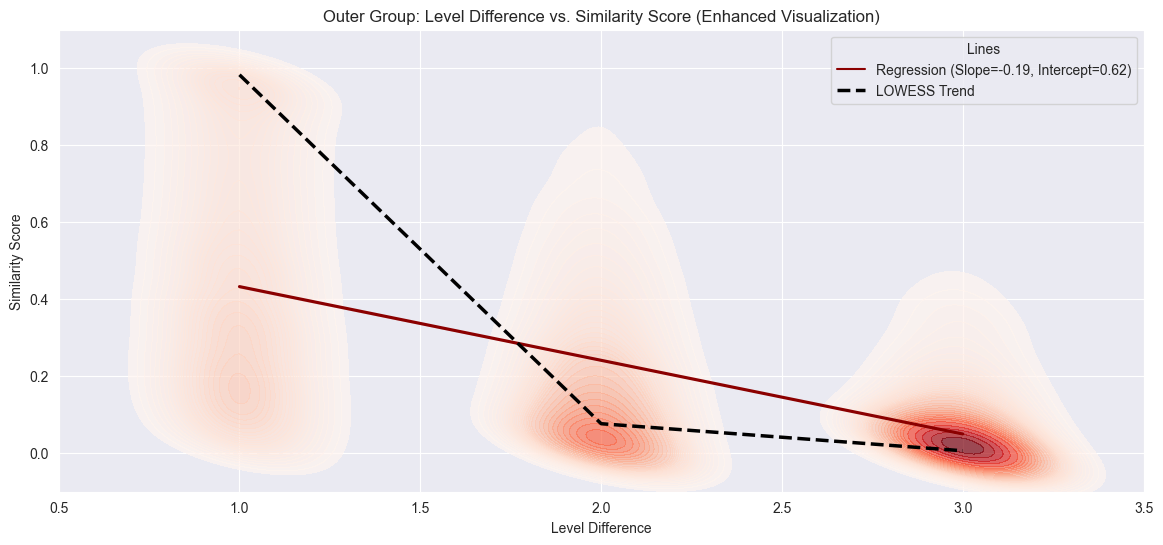

Sample counts per Level Difference after balancing:
Level_Difference
1    14511
2    14511
3    14511
Name: count, dtype: int64


In [46]:

# Group by Level Difference and find the minimum sample size
grouped = outer_group_df.groupby('Level_Difference')
min_samples = grouped.size().min()

# Downsample each group to the minimum size
balanced_df = grouped.apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)

# Compute Spearman correlation for the balanced group
spearman_corr, spearman_p = spearmanr(balanced_df['Level_Difference'], balanced_df['Similarity_Score'])
print(f"Spearman Correlation (Balanced): {spearman_corr:.3f}, p-value: {spearman_p:.3f}")

# Compute regression slope and intercept using linear regression
slope, intercept, r_value, p_value, std_err = linregress(balanced_df['Level_Difference'], balanced_df['Similarity_Score'])
print(f"Regression Slope: {slope:.3f}, Intercept: {intercept:.3f}")

# LOWESS Smoothing for the downward trend
lowess_smoothed = lowess(
    balanced_df['Similarity_Score'], 
    balanced_df['Level_Difference'], 
    frac=0.3
)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))  # Wider plot for better KDE visibility

# KDE plot for density visualization
sns.kdeplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=balanced_df,
    fill=True,
    cmap='Reds',  # Use color gradient from the older plot
    alpha=0.7,    # Match transparency from the older plot
    ax=ax,
    thresh=0.05,  # Include KDE threshold from older plot
    levels=40     # Increase contours for more detail
)

# Regression line with confidence interval
sns.regplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=balanced_df,
    scatter=False,
    color='darkred',  # Match the regression line color from older plot
    ci=95,  # Confidence interval
    n_boot=2000,
    ax=ax
)

# Add regression line attributes manually to the legend
ax.plot([], [], color='darkred', label=f"Regression (Slope={slope:.2f}, Intercept={intercept:.2f})")

# Plot the smoothed LOWESS curve
ax.plot(
    lowess_smoothed[:, 0], 
    lowess_smoothed[:, 1], 
    color='black',  # Black LOWESS line for contrast
    linestyle='--', 
    linewidth=2.5, 
    label='LOWESS Trend'
)

# Customize the plot
plt.title('Outer Group: Level Difference vs. Similarity Score (Enhanced Visualization)')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.xlim(balanced_df['Level_Difference'].min() - 0.5, balanced_df['Level_Difference'].max() + 0.5)  # Add padding to edges
plt.ylim(balanced_df['Similarity_Score'].min() - 0.1, balanced_df['Similarity_Score'].max() + 0.1)

# Add legend
plt.legend(title='Lines', loc='upper right')

# Show the plot
plt.show()

# Display the number of samples per group
sample_counts = balanced_df['Level_Difference'].value_counts()
print("Sample counts per Level Difference after balancing:")
print(sample_counts)

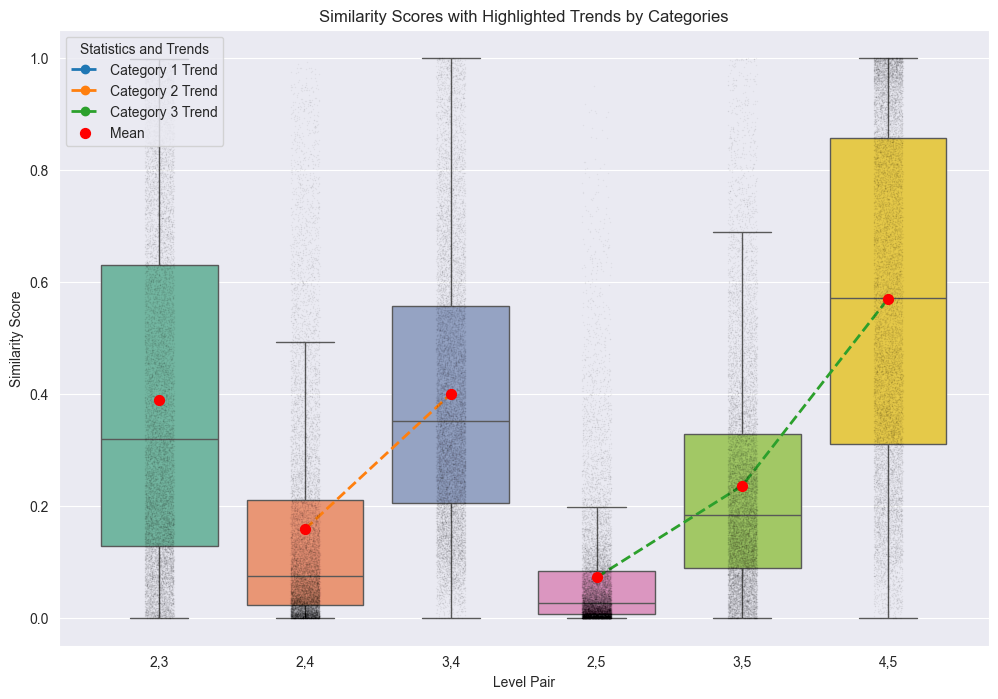

In [47]:
# Categorize the Level_Pairs into three groups for highlighting trends
def categorize_level_pair(level_pair):
    if level_pair == "2,3":
        return "Category 1"
    elif level_pair in ["2,4", "3,4"]:
        return "Category 2"
    elif level_pair in ["2,5", "3,5", "4,5"]:
        return "Category 3"
    return "Other"

# Add category information to the dataframe
outer_group_df['Category'] = outer_group_df['Level_Pair'].apply(categorize_level_pair)

plt.figure(figsize=(12, 8))

# Boxplot for Outer Group
sns.boxplot(
    x='Level_Pair', 
    y='Similarity_Score', 
    data=outer_group_df, 
    palette='Set2', 
    showfliers=False  # Suppress default outliers
)

# Add outliers separately for customization
sns.stripplot(
    x='Level_Pair', 
    y='Similarity_Score', 
    data=outer_group_df, 
    color='black', 
    alpha=0.05,  # Slightly more opaque for better visibility
    jitter=True, 
    size=1
)

# Add mean values
mean_values = outer_group_df.groupby(['Category', 'Level_Pair'])['Similarity_Score'].mean().reset_index()

# Plot the means and connect them within categories
for category, group_data in mean_values.groupby('Category'):
    positions = [list(outer_group_df['Level_Pair'].unique()).index(pair) for pair in group_data['Level_Pair']]
    plt.plot(
        positions, 
        group_data['Similarity_Score'], 
        label=f'{category} Trend', 
        linestyle='--', 
        marker='o', 
        linewidth=2
    )

# Scatterplot for mean points
plt.scatter(
    x=[list(outer_group_df['Level_Pair'].unique()).index(pair) for pair in mean_values['Level_Pair']], 
    y=mean_values['Similarity_Score'], 
    color='red', 
    label='Mean', 
    zorder=5,  # Keep it on top of other elements
    s=50
)

# Add legend
plt.legend(title='Statistics and Trends', loc='upper left')

# Customize labels and title
plt.title('Similarity Scores with Highlighted Trends by Categories')
plt.xlabel('Level Pair')
plt.ylabel('Similarity Score')

plt.show()

In [48]:
# Define subsets based on user observation
subset1_pairs = [(2,4), (3,4)]
subset2_pairs = [(2,5), (3,5), (4,5)]

subset1_df = outer_group_df[outer_group_df['Level_Pair'].isin([f"{a},{b}" for a,b in subset1_pairs])]
subset2_df = outer_group_df[outer_group_df['Level_Pair'].isin([f"{a},{b}" for a,b in subset2_pairs])]

# Spearman Correlation for Subset 1
spearman_corr_sub1, spearman_p_sub1 = stats.spearmanr(subset1_df['Level_Difference'], subset1_df['Similarity_Score'])
print("Spearman Correlation for Outer Group Subset 1 (2,4 and 3,4):")
print(f"Correlation: {spearman_corr_sub1:.3f}, p-value: {spearman_p_sub1:.3f}\n")

# Spearman Correlation for Subset 2
spearman_corr_sub2, spearman_p_sub2 = stats.spearmanr(subset2_df['Level_Difference'], subset2_df['Similarity_Score'])
print("Spearman Correlation for Outer Group Subset 2 (2,5; 3,5; 4,5):")
print(f"Correlation: {spearman_corr_sub2:.3f}, p-value: {spearman_p_sub2:.3f}\n")

Spearman Correlation for Outer Group Subset 1 (2,4 and 3,4):
Correlation: -0.550, p-value: 0.000

Spearman Correlation for Outer Group Subset 2 (2,5; 3,5; 4,5):
Correlation: -0.731, p-value: 0.000



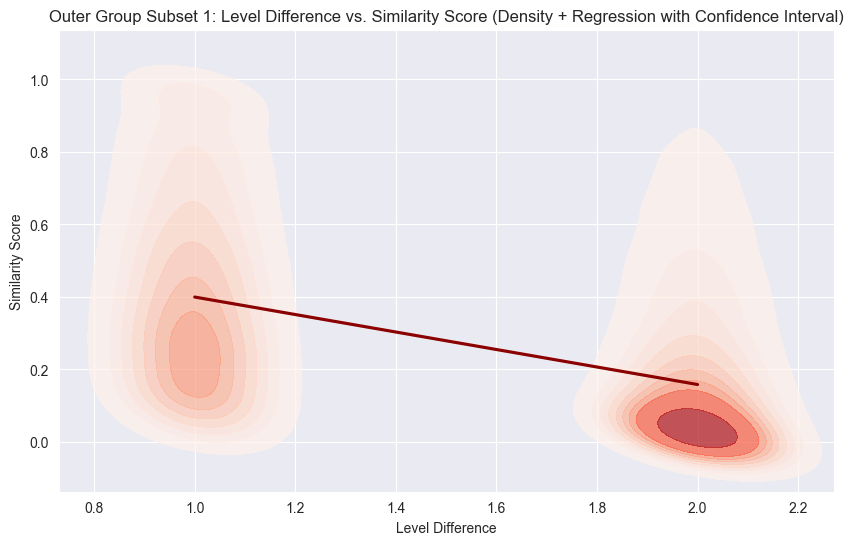

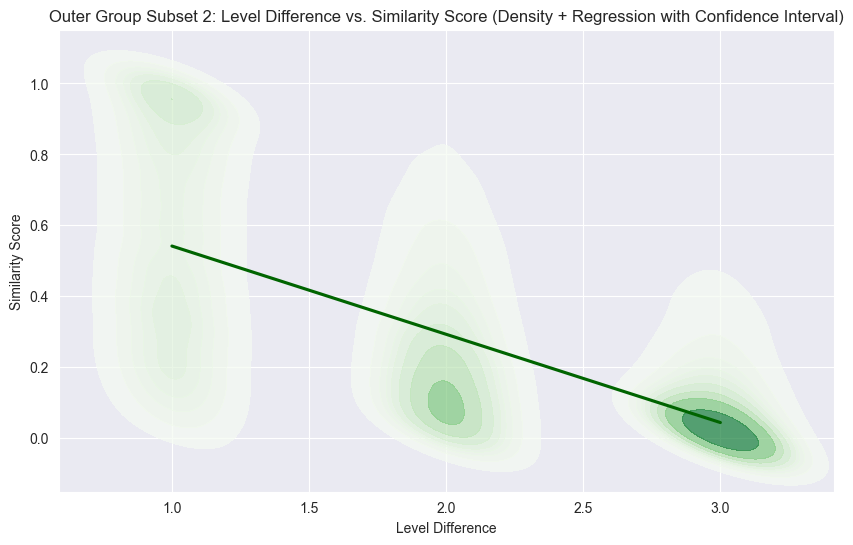

In [49]:
# Visualization for Subset 1: KDE + Regression Line with Confidence Interval
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset1_df,
    fill=True,
    cmap='Reds',
    thresh=0.05,
    alpha=0.7
)
sns.regplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset1_df,
    scatter=False,
    color='darkred',
    ci=95  # 95% confidence interval
)
plt.title('Outer Group Subset 1: Level Difference vs. Similarity Score (Density + Regression with Confidence Interval)')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.show()

# Visualization for Subset 2: KDE + Regression Line with Confidence Interval
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset2_df,
    fill=True,
    cmap='Greens',
    thresh=0.05,
    alpha=0.7
)
sns.regplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset2_df,
    scatter=False,
    color='darkgreen',
    ci=55  # 95% confidence interval
)
plt.title('Outer Group Subset 2: Level Difference vs. Similarity Score (Density + Regression with Confidence Interval)')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.show()

# **DreaMS Embedding**

In [50]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [51]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1,
            'bin_width': 1.0,
        },
    },
}

featurizer = SpectrumFeaturizer(config, mode='torch')

In [52]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [53]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

In [54]:
# MS-Level Pair Analysis (embedding-based)
all_level_sims_dreams = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=True, sim_fn=None, embeddings_dict=embeddings_dict, descendant_mode=True
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        if (lvlA, lvlB) not in all_level_sims_dreams:
            all_level_sims_dreams[(lvlA, lvlB)] = []
        all_level_sims_dreams[(lvlA, lvlB)].extend(simvals)

In [55]:
# MS2 <-> MS2 (embedding-based) with limited pairs
ms2_sims_dreams = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=True,
    sim_fn=None,
    embeddings_dict=embeddings_dict,
    max_pairs=25000 
)

In [56]:
# Initialize (2,2) if not present
if (2, 2) not in all_level_sims_dreams:
    all_level_sims_dreams[(2, 2)] = []

all_level_sims_dreams[(2, 2)].extend(ms2_sims_dreams)

In [57]:
for level_pair in all_level_sims_dreams.keys():
    all_level_sims_dreams[level_pair] = convert_similarity_scores(all_level_sims_dreams[level_pair])

In [ ]:
# Print average for each level pair
for level_pair, vals in all_level_sims_dreams.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

In [ ]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
comparison_results_dreams = perform_statistical_tests_with_effect_sizes(all_level_sims_dreams, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_dreams)

In [ ]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims_dreams, mode="DreaMS Embeddings")

In [ ]:
plot_boxplots(all_level_sims_dreams, "Boxplots of Similarity Scores by MS Level Pair (Dreams)")

In [ ]:
plot_density(all_level_sims_dreams, "Density Plots of Similarity Scores by MS Level Pair (Dreams)")

In [ ]:
plot_comparative_histogram(all_level_sims_dreams, (2, 2), (4, 5), "Comparative Histogram of (2,2) vs (2,3)")

In [ ]:
# Generate the summary tables
ks_summary_df, aic_summary_df = summarize_all_level_pairs(all_level_sims_dreams, top_n=5)

# Display KS Summary Table
print("\nTop 5 Best-Fitting Distributions Based on KS Statistic:")
display(ks_summary_df)

# Display AIC Summary Table
print("\nTop 5 Best-Fitting Distributions Based on AIC:")
display(aic_summary_df)

In [ ]:
# Plotting Best-Fitting Distributions Based on KS Statistic
print("\nPlotting Best-Fitting Distributions Based on KS Statistic:")
plot_best_fit(
    summary_df=ks_summary_df,
    all_level_sims=all_level_sims_dreams,
    criterion='KS Statistic',
    save_plots=False  
)

In [ ]:
# Plotting Best-Fitting Distributions Based on AIC
print("\nPlotting Best-Fitting Distributions Based on AIC:")
plot_best_fit(
    summary_df=aic_summary_df,
    all_level_sims=all_level_sims_dreams,
    criterion='AIC',
    save_plots=False  
)

## **Sample**

In [ ]:
sampled_all_level_sims = downsample_all_level_sims(all_level_sims_dreams, random_seed=42)

In [ ]:
# Print average for each level pair
for level_pair, vals in sampled_all_level_sims.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

In [ ]:
# Summarize and perform statistical tests for cosine DreaMS similarities
print("\n--- Statistical Analysis for Sampled DreaMS Embeddings Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(sampled_all_level_sims, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_dreams)

In [ ]:
plot_density(sampled_all_level_sims, "Density Plots of Similarity Scores by MS Level Pair (DreaMS)")

## Correlation

In [ ]:
data = []
for level_pair, sims in sampled_all_level_sims.items():
    lvlA, lvlB = level_pair
    for sim in sims:
        data.append({
            'Level_A': lvlA,
            'Level_B': lvlB,
            'Similarity_Score': sim
        })

df = pd.DataFrame(data)

# Compute Avg_Level and Level_Difference
df['Avg_Level'] = df[['Level_A', 'Level_B']].mean(axis=1)
df['Level_Difference'] = abs(df['Level_A'] - df['Level_B'])

# Create a categorical variable for Level_Pair
df['Level_Pair'] = df.apply(lambda row: f"{int(row['Level_A'])},{int(row['Level_B'])}", axis=1)

# Display the first few rows
display(df.head())

# Group by Level Pair and compute descriptive statistics
grouped = df.groupby(['Level_A', 'Level_B'])

# Compute mean, median, std, and count similarity scores
stats_df = grouped['Similarity_Score'].agg(['mean', 'median', 'std', 'count']).reset_index()
stats_df.rename(columns={
    'mean': 'Mean_Similarity',
    'median': 'Median_Similarity',
    'std': 'Std_Similarity',
    'count': 'Count'
}, inplace=True)

# Compute additional hierarchy metrics
stats_df['Avg_Level'] = stats_df[['Level_A', 'Level_B']].mean(axis=1)
stats_df['Level_Difference'] = abs(stats_df['Level_A'] - stats_df['Level_B'])

# Optional: Plot the distribution of Similarity_Score
plt.figure(figsize=(10, 6))
sns.histplot(df['Similarity_Score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Similarity Scores (Individual Data Points)')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

# Check for skewness
skewness = df['Similarity_Score'].skew()
print(f"Skewness of Similarity_Score: {skewness:.3f}")

dependent_var = 'Similarity_Score'

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Similarity_Score_Log'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Similarity Scores (Individual Data Points)')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Avg_Level', y='Mean_Similarity', data=stats_df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Average Level vs. Mean Similarity')
plt.xlabel('Average Level')
plt.ylabel('Mean Similarity')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Level_Difference', y='Mean_Similarity', data=stats_df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Level Difference vs. Mean Similarity')
plt.xlabel('Level Difference')
plt.ylabel('Mean Similarity')
plt.show()

In [ ]:
# Heatmap of Correlation Matrix
corr_matrix = stats_df[['Avg_Level', 'Level_Difference', 'Mean_Similarity', 'Median_Similarity', 'Std_Similarity']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Hierarchy Metrics and Similarity Statistics')
plt.show()

In [ ]:
# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(stats_df['Avg_Level'], stats_df['Mean_Similarity'])
print(f"Spearman Correlation between Avg_Level and Mean_Similarity: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")

In [ ]:
# Spearman correlation between Avg_Level and Similarity_Score
spearman_corr, spearman_p = stats.spearmanr(df['Avg_Level'], df['Similarity_Score'])
print(f"Spearman Correlation between Avg_Level and Similarity_Score: {spearman_corr:.3f}")
print(f"P-value: {spearman_p:.3f}")

In [ ]:
# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(stats_df['Level_Difference'], stats_df['Mean_Similarity'])
print(f"Spearman Correlation between Level_Difference and Mean_Similarity: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")

In [ ]:
# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(df['Level_Difference'], df['Similarity_Score'])
print(f"Spearman Correlation between Level_Difference and Similarity_Score: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")